In [1]:
# src: https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

In [2]:
# !https://github.com/AmmarBagharib/sentiment_analysis_bt4222.git

In [3]:
# !git clone https://token@github.com/AmmarBagharib/sentiment_analysis_bt4222.git

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import datetime

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pyprojroot.here as here

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

## Loading the Data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
star3 = ['cleaned_ibis-sg-bencoolen.csv','cleaned_hotel-boss.csv','cleaned_hotel-G.csv',
           'cleaned_village-hotel-albert-court-by-far-east-hospitality.csv',
           'cleaned_holiday-inn-express-clarke-quay.csv']
star4 = ['cleaned_village-hotel-changi-by-far-east-hospitality.csv',
         'cleaned_park-regis.csv', 'cleaned_grand-mercure-sg-roxy.csv',
         'cleaned_paradox-sg-merchant-court.csv','cleaned_crowne-plaza.csv']
star5 = ['cleaned_fullerton.csv', 'cleaned_parkroyal-collection-marina-bay.csv', 'cleaned_pan-pacific.csv',
          'cleaned_mbs_total.csv', 'cleaned_swissotel-the-stamford.csv']

def filter_date(row):
  try:
    #print(int(row["date_of_stay"][-4:]))
    return int(row["date_of_stay"][-4:])
  except:
    #print("2000")
    return 2000
def combine_csv_to_dataframe(file_names, all_star = False):
    """
    Combine multiple CSV files into a single DataFrame.

    Parameters:
    file_names (list): List of CSV file names.

    Returns:
    pd.DataFrame: Combined DataFrame.
    """
    combined_df = pd.DataFrame()

    for file_name in file_names:
        hotel_name = file_name.replace("cleaned_", "").replace(".csv", "")
        file_path = 'data/cleaned/' + file_name
        file_path = here(file_path)
        try:
            df = pd.read_csv(file_path)
            df['hotel_name'] = hotel_name
            if all_star:
              if file_name in star3:
                df["star"] = 3
              elif file_name in star4:
                df["star"] = 4
              else:
                df["star"] = 5
            print(f"Length of {file_name} is {len(df)}")
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"Empty or invalid CSV file: {file_name}")
    combined_df["year"] = combined_df.apply(lambda row: filter_date(row), axis = 1)
    combined_df = combined_df[combined_df["year"]>=2015]
    return combined_df

In [5]:
data = combine_csv_to_dataframe(star3+star4+star5, all_star = True)
#data[['traveller_username','date','travel_type','traveller_total_contributions','traveller_total_helpful_contributions','review_title','review_text','rating']].head(5)
data.info()
data.head(3)

Length of cleaned_ibis-sg-bencoolen.csv is 5933
Length of cleaned_hotel-boss.csv is 3568
Length of cleaned_hotel-G.csv is 3829
Length of cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 3285
Length of cleaned_holiday-inn-express-clarke-quay.csv is 2551
Length of cleaned_village-hotel-changi-by-far-east-hospitality.csv is 5621
Length of cleaned_park-regis.csv is 5298
Length of cleaned_grand-mercure-sg-roxy.csv is 5015
Length of cleaned_paradox-sg-merchant-court.csv is 5813
Length of cleaned_crowne-plaza.csv is 5743
Length of cleaned_fullerton.csv is 7975
Length of cleaned_parkroyal-collection-marina-bay.csv is 8129
Length of cleaned_pan-pacific.csv is 10797
Length of cleaned_mbs_total.csv is 19371
Length of cleaned_swissotel-the-stamford.csv is 8833
<class 'pandas.core.frame.DataFrame'>
Index: 68292 entries, 0 to 98107
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,rating,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,star,year
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,4.0,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,5.0,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,5.0,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,3,2022


In [6]:
# Convert the 'date' column to datetime objects
data['date'] = pd.to_datetime(data['date'])

# Group by 'hotel_name' and resample by month, then count the reviews in each group
review_counts = data.groupby(['hotel_name', 'star', pd.Grouper(key='date', freq='M')])['cleaned_review'].count().reset_index()
review_counts

,hotel_name,star,date,cleaned_review
0,crowne-plaza,4,2015-01-31,48
1,crowne-plaza,4,2015-02-28,49
2,crowne-plaza,4,2015-03-31,61
3,crowne-plaza,4,2015-04-30,49
4,crowne-plaza,4,2015-05-31,46
...,...,...,...,...
1369,village-hotel-changi-by-far-east-hospitality,4,2023-05-31,45
1370,village-hotel-changi-by-far-east-hospitality,4,2023-06-30,46
1371,village-hotel-changi-by-far-east-hospitality,4,2023-07-31,27
1372,village-hotel-changi-by-far-east-hospitality,4,2023-08-31,32


In [7]:
average_reviews_per_month = review_counts.groupby(['hotel_name', 'star'])['cleaned_review'].mean().reset_index()
average_reviews_per_month.sort_values('cleaned_review', ascending=False)

,hotel_name,star,cleaned_review
7,mbs_total,5,100.219048
8,pan-pacific,5,72.843137
11,parkroyal-collection-marina-bay,5,63.642857
1,fullerton,5,60.704762
14,village-hotel-changi-by-far-east-hospitality,4,57.666667
12,swissotel-the-stamford,5,54.978261
4,hotel-G,3,47.234568
10,park-regis,4,45.375000
5,hotel-boss,3,41.011494
9,paradox-sg-merchant-court,4,40.123596


In [8]:
data.groupby(['hotel_name', 'star'])['cleaned_review'].count().sort_values(ascending=False)

hotel_name                                          star
mbs_total                                           5       10523
pan-pacific                                         5        7430
fullerton                                           5        6374
parkroyal-collection-marina-bay                     5        6237
swissotel-the-stamford                              5        5058
park-regis                                          4        4719
village-hotel-changi-by-far-east-hospitality        4        4325
hotel-G                                             3        3826
crowne-plaza                                        4        3668
paradox-sg-merchant-court                           4        3571
hotel-boss                                          3        3568
grand-mercure-sg-roxy                               4        2317
village-hotel-albert-court-by-far-east-hospitality  3        2290
ibis-sg-bencoolen                                   3        2217
holiday-inn-express

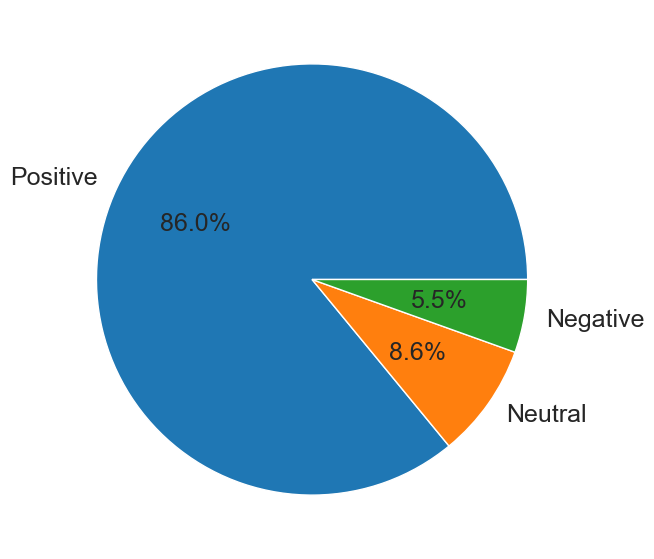

In [9]:
plt.pie(data['label'].dropna().value_counts(), labels=data['label'].dropna().unique().tolist(), autopct='%1.1f%%')
plt.show()

In [10]:
data3 = combine_csv_to_dataframe(star3, all_star = False)
data4 = combine_csv_to_dataframe(star4, all_star = False)
data5 = combine_csv_to_dataframe(star5, all_star = False)


Length of cleaned_ibis-sg-bencoolen.csv is 5933
Length of cleaned_hotel-boss.csv is 3568
Length of cleaned_hotel-G.csv is 3829
Length of cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 3285
Length of cleaned_holiday-inn-express-clarke-quay.csv is 2551
Length of cleaned_village-hotel-changi-by-far-east-hospitality.csv is 5621
Length of cleaned_park-regis.csv is 5298
Length of cleaned_grand-mercure-sg-roxy.csv is 5015
Length of cleaned_paradox-sg-merchant-court.csv is 5813
Length of cleaned_crowne-plaza.csv is 5743
Length of cleaned_fullerton.csv is 7975
Length of cleaned_parkroyal-collection-marina-bay.csv is 8129
Length of cleaned_pan-pacific.csv is 10797
Length of cleaned_mbs_total.csv is 19371
Length of cleaned_swissotel-the-stamford.csv is 8833


In [11]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35622 entries, 0 to 51451
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             35622 non-null  int64  
 1   date_of_stay                           35622 non-null  object 
 2   traveller_username                     35622 non-null  object 
 3   review_title                           35590 non-null  object 
 4   review_text                            35622 non-null  object 
 5   travel_type                            17966 non-null  object 
 6   traveller_country_origin               26579 non-null  object 
 7   traveller_total_contributions          35484 non-null  object 
 8   traveller_total_helpful_contributions  29592 non-null  float64
 9   rating1                                26999 non-null  object 
 10  rating2                                8618 non-null   float64
 11  rating 

In [12]:
# combine raw title and review
#def combine(r):
#  return str(r['review_title']) + " " + str(r['review_text'])

# Exploratory Data Analysis

## Review title and text

### Counts and Length:
Start by checking how long the reviews are
* Character count
* Word count
* Mean word length
* Mean sentence length

In [13]:
length = len(data['cleaned_review'][0])
print(f'Length of a sample review: {length}')

Length of a sample review: 550


In [14]:
data['Length'] = data['cleaned_review'].str.len()
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,star,year,Length
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,550
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,139
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,3,2022,203
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,...,True,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,203
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,...,True,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,3,2022,181
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,...,True,Positive,excellent service taste team another excellent...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,252
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,...,True,Positive,great care provide hotel engineering team clea...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,440
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,...,True,Positive,good hotel stay hotel numerous time remain pre...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,ibis-sg-bencoolen,3,2023,493
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,...,True,Positive,special third stay amazing always ibis bencool...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,ibis-sg-bencoolen,3,2022,215
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great location,Clean hotel in a convenient location. They hav...,Trip type: Travelled with family,"Bengaluru, India",159.0,145.0,4.0,...,True,Positive,clean hotel great location clean hotel conveni...,Clean hotel at a great location Clean hotel in...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,462


#### **Word Count**: Number of words in a review

In [15]:
word_count = data['cleaned_review'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 84


In [16]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [17]:
data['Word_count'] = data['cleaned_review'].apply(word_count)
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,label,cleaned_review,combined_review,date,covid,hotel_name,star,year,Length,Word_count
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,550,84
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,139,22
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,3,2022,203,34
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,...,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,203,33
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,...,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,3,2022,181,30
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,...,Positive,excellent service taste team another excellent...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,252,37
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,...,Positive,great care provide hotel engineering team clea...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,440,62
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,...,Positive,good hotel stay hotel numerous time remain pre...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,ibis-sg-bencoolen,3,2023,493,76
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,...,Positive,special third stay amazing always ibis bencool...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,ibis-sg-bencoolen,3,2022,215,32
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great location,Clean hotel in a convenient location. They hav...,Trip type: Travelled with family,"Bengaluru, India",159.0,145.0,4.0,...,Positive,clean hotel great location clean hotel conveni...,Clean hotel at a great location Clean hotel in...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,462,70


#### **Mean word length**: Average length of words

In [18]:
data['mean_word_length'] = data['cleaned_review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,cleaned_review,combined_review,date,covid,hotel_name,star,year,Length,Word_count,mean_word_length
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,550,84,5.559524
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,139,22,5.363636
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,3,2022,203,34,5.000000
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,...,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,203,33,5.181818
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,...,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,3,2022,181,30,5.066667
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,...,excellent service taste team another excellent...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,252,37,5.837838
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,...,great care provide hotel engineering team clea...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,440,62,6.112903
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,...,good hotel stay hotel numerous time remain pre...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,ibis-sg-bencoolen,3,2023,493,76,5.500000
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,...,special third stay amazing always ibis bencool...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,ibis-sg-bencoolen,3,2022,215,32,5.750000
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great location,Clean hotel in a convenient location. They hav...,Trip type: Travelled with family,"Bengaluru, India",159.0,145.0,4.0,...,clean hotel great location clean hotel conveni...,Clean hotel at a great location Clean hotel in...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,462,70,5.614286


#### **Mean sentence length**: Average length of the sentences in the review

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ammarbagharib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['cleaned_review'][0])])

550.0

In [21]:
data['mean_sent_length'] = data['cleaned_review'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,combined_review,date,covid,hotel_name,star,year,Length,Word_count,mean_word_length,mean_sent_length
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,550,84,5.559524,550.0
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,139,22,5.363636,139.0
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,3,2022,203,34,5.000000,203.0
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,203,33,5.181818,203.0
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,3,2022,181,30,5.066667,181.0
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,252,37,5.837838,252.0
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,440,62,6.112903,440.0
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,ibis-sg-bencoolen,3,2023,493,76,5.500000,493.0
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,ibis-sg-bencoolen,3,2022,215,32,5.750000,215.0
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great location,Clean hotel in a convenient location. They hav...,Trip type: Travelled with family,"Bengaluru, India",159.0,145.0,4.0,...,Clean hotel at a great location Clean hotel in...,2023-06-01,PostCovid,ibis-sg-bencoolen,3,2023,462,70,5.614286,462.0


In [22]:
def visualize(col):

    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=data[col], hue=data['label'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(data = data, x = col, hue='label')
    plt.legend(data['label'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

In [23]:
data.columns

Index(['Unnamed: 0', 'date_of_stay', 'traveller_username', 'review_title',
       'review_text', 'travel_type', 'traveller_country_origin',
       'traveller_total_contributions',
       'traveller_total_helpful_contributions', 'rating1', 'rating2', 'rating',
       'valid_rating', 'label', 'cleaned_review', 'combined_review', 'date',
       'covid', 'hotel_name', 'star', 'year', 'Length', 'Word_count',
       'mean_word_length', 'mean_sent_length'],
      dtype='object')

Length



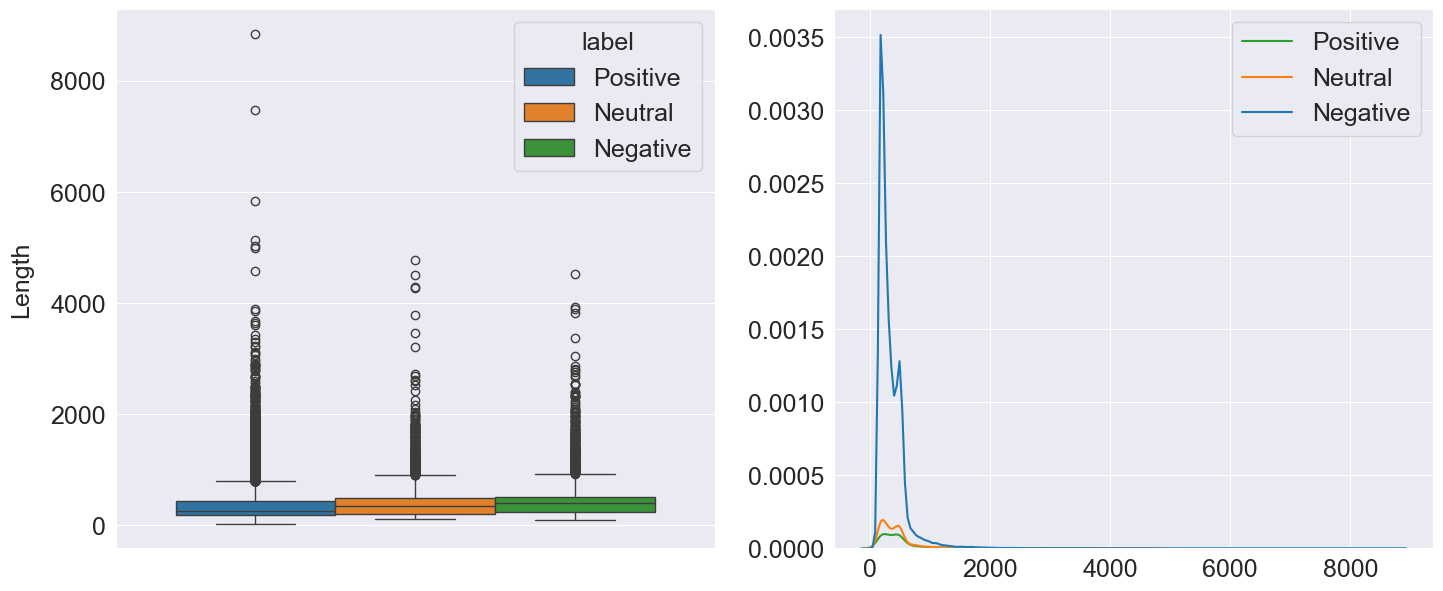

Word_count



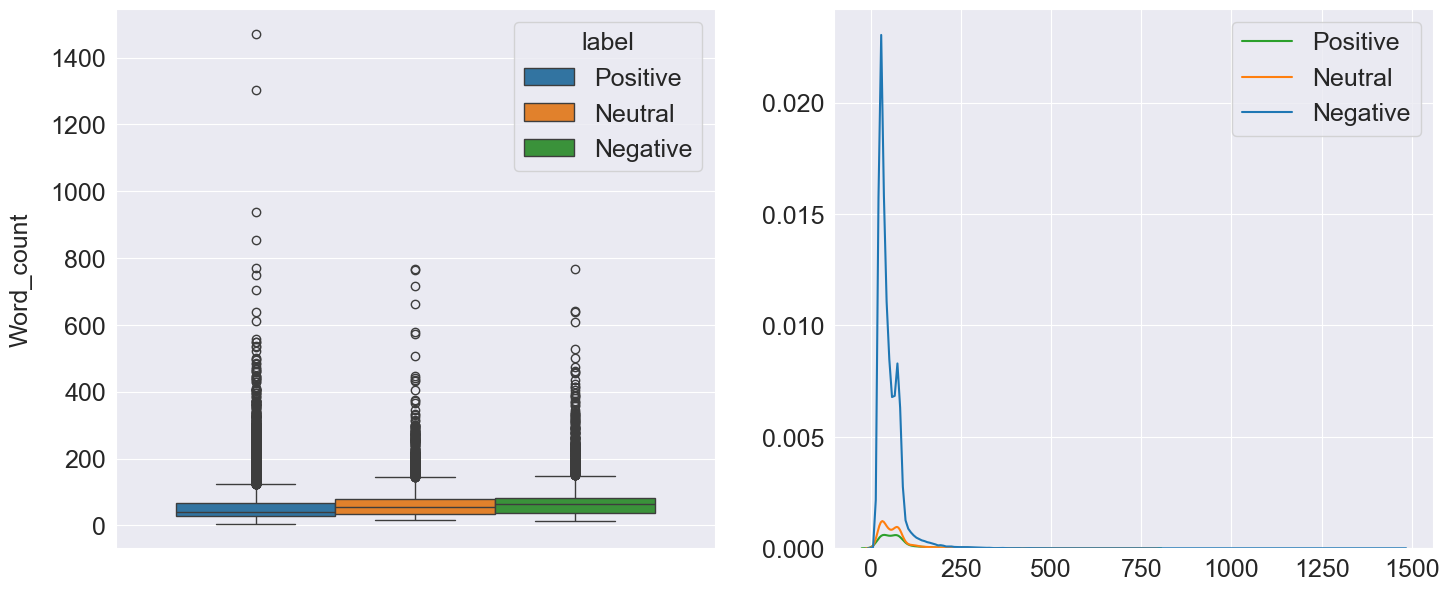

mean_word_length



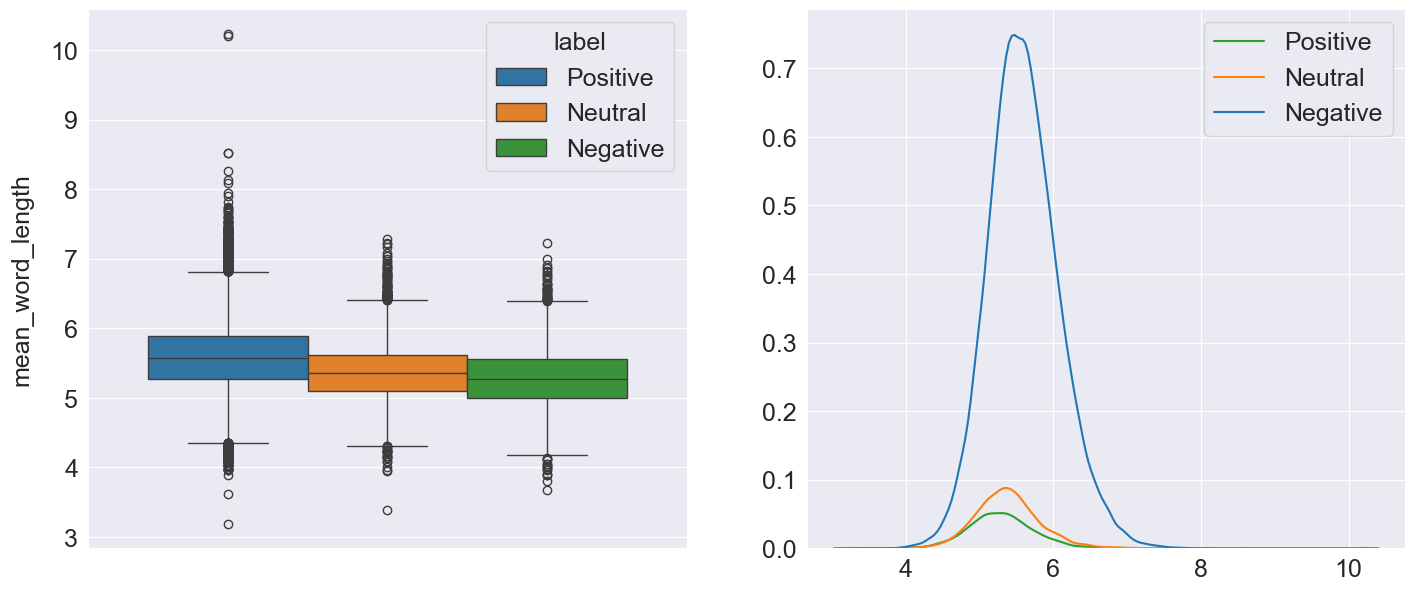

mean_sent_length



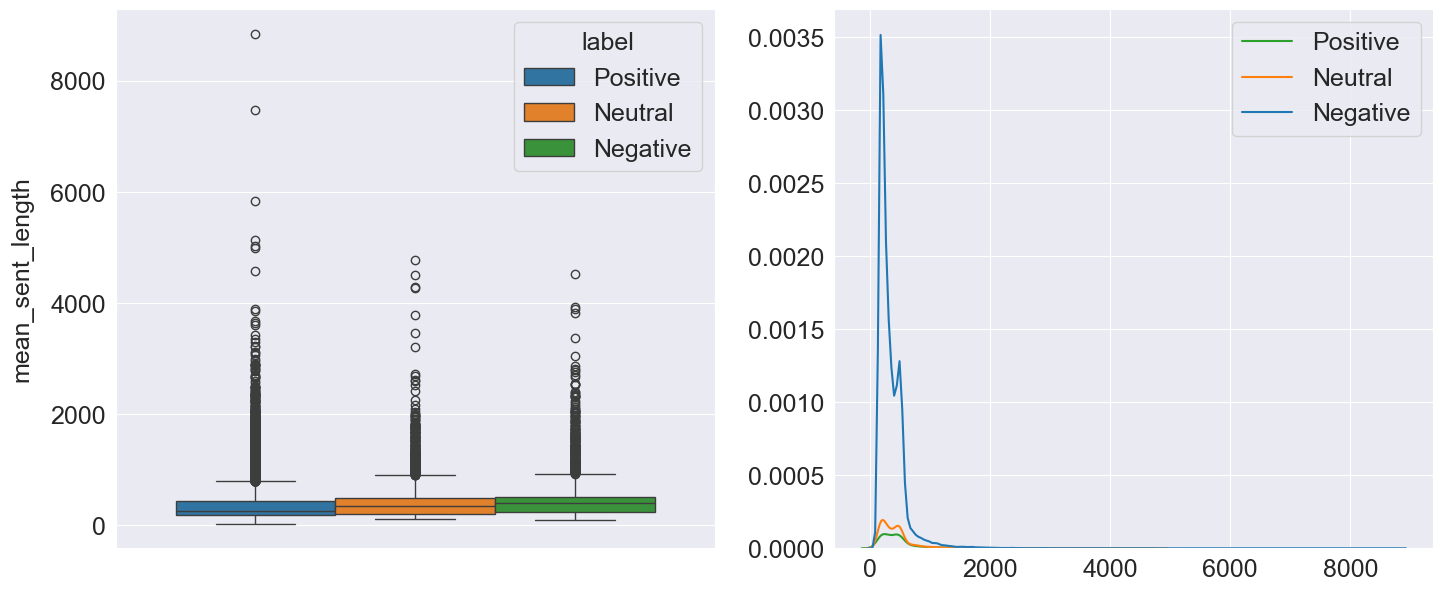

In [24]:
features = ['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']
for feature in features:
    print(feature)
    visualize(feature)

### Term Frequency Analysis
Examining the most frequently occuring words is one of the most popular systems of Text analytics. For example, in a sentiment analysis problem, a positive text is bound to have words like 'good', 'great', 'nice', etc. more in number than other words that imply otherwise.

*Note*: Term Frequencies are more than counts and lenghts, so the first requirement is to preprocess the text

In [28]:
#df = data.drop(features, axis=1)
df = data3
df

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,year
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,4.0,4.0,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,2023
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,NaN,5.0,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,2023
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,NaN,5.0,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,2022
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,NaN,5.0,True,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,2023
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,4.0,4.0,True,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18814,2199,Date of stay: January 2015,furam,small but enough,i stay from 1/6 to 1/9\nthe location is excell...,NaN,NaN,14.0,31.0,NaN,4.0,4.0,True,Positive,small enough I stay location excellet close mr...,small but enough i stay from 1/6 to 1/9\nthe l...,2015-01-01,PreCovid,holiday-inn-express-clarke-quay,2015
18816,2201,Date of stay: January 2015,Ajmal A,Great Experience,I visited Singapore recently with family for a...,NaN,NaN,4.0,8.0,5.0,NaN,5.0,True,Positive,great experience I visit singapore recently fa...,Great Experience I visited Singapore recently ...,2015-01-01,PreCovid,holiday-inn-express-clarke-quay,2015
18817,2202,Date of stay: January 2015,Fciona,"Good hotel, great location..",My husband and I stayed here for the 4 nights ...,NaN,"Sydney, Australia",70.0,70.0,4.0,NaN,4.0,True,Positive,good hotel great location husband I stay night...,"Good hotel, great location.. My husband and I ...",2015-01-01,PreCovid,holiday-inn-express-clarke-quay,2015
18821,2206,Date of stay: January 2015,RoySensei,My stay at this hotel,"The staff were all friendly and efficient, the...",NaN,"Mount Claremont, Australia",109.0,14.0,3.0,NaN,3.0,True,Neutral,stay hotel staff friendly efficient room adequ...,My stay at this hotel The staff were all frien...,2015-01-01,PreCovid,holiday-inn-express-clarke-quay,2015


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14070 entries, 0 to 18823
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             14070 non-null  int64  
 1   date_of_stay                           14070 non-null  object 
 2   traveller_username                     14070 non-null  object 
 3   review_title                           14068 non-null  object 
 4   review_text                            14070 non-null  object 
 5   travel_type                            4635 non-null   object 
 6   traveller_country_origin               9922 non-null   object 
 7   traveller_total_contributions          14041 non-null  object 
 8   traveller_total_helpful_contributions  9935 non-null   float64
 9   rating1                                12503 non-null  float64
 10  rating2                                1566 non-null   float64
 11  rating 

There is no missing data, therefore, we can move to the next stage. For Term frequency analysis, it is essential that the text data be preprocessed.
* Lowercase
* Remove punctutations
* Stopword removal

In [30]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ammarbagharib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
#df['combined_review'] = df['combined_review'].apply(clean)
#df.head(10)

In [33]:
df['cleaned_review'][0]

'clean comfortable hotel room singapore expensive find decent hotel easy transport access food location less good deal compact room meet basic need fancy mood lightning lovely artwork grace wall clean sheet towel small bathroom pump pack amenity kettle glass bottle refill small selection tea coffee small fridge room safe closet space quite limited iron board I use luggage rack bathrobe pair complimentary slipper usb port sufficient electrical point location good bugis st bencoolen rochor st mrt within walk distance behind hotel massive night day'

In [34]:
def corpus(text):
    text_list = text.split()
    return text_list

In [35]:
df['Review_lists'] = df['cleaned_review'].apply(corpus)
df.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,rating,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,year,Review_lists
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,4.0,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,2023,"[clean, comfortable, hotel, room, singapore, e..."
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,5.0,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,2023,"[good, hotel, great, location, great, place, l..."
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,5.0,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,2022,"[good, place, decent, price, good, place, good..."
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,...,5.0,True,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,2023,"[great, location, great, staff, ibis, neat, ti..."
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,...,4.0,True,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,2022,"[good, budget, stay, I, stay, day, nice, locat..."
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,...,5.0,True,Positive,excellent service taste team another excellent...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,ibis-sg-bencoolen,2023,"[excellent, service, taste, team, another, exc..."
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,...,5.0,True,Positive,great care provide hotel engineering team clea...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,ibis-sg-bencoolen,2023,"[great, care, provide, hotel, engineering, tea..."
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,...,4.0,True,Positive,good hotel stay hotel numerous time remain pre...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,ibis-sg-bencoolen,2023,"[good, hotel, stay, hotel, numerous, time, rem..."
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,...,5.0,True,Positive,special third stay amazing always ibis bencool...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,ibis-sg-bencoolen,2022,"[special, third, stay, amazing, always, ibis, ..."
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great l

In [36]:
df  = df.reset_index()

In [37]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Review_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14070/14070 [00:00<00:00, 195399.77it/s]


675993

In [38]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('hotel', 23561),
 ('room', 21816),
 ('I', 17832),
 ('good', 13764),
 ('stay', 12388),
 ('staff', 8364),
 ('location', 7948),
 ('great', 7585),
 ('small', 6476),
 ('breakfast', 6264)]

In [39]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

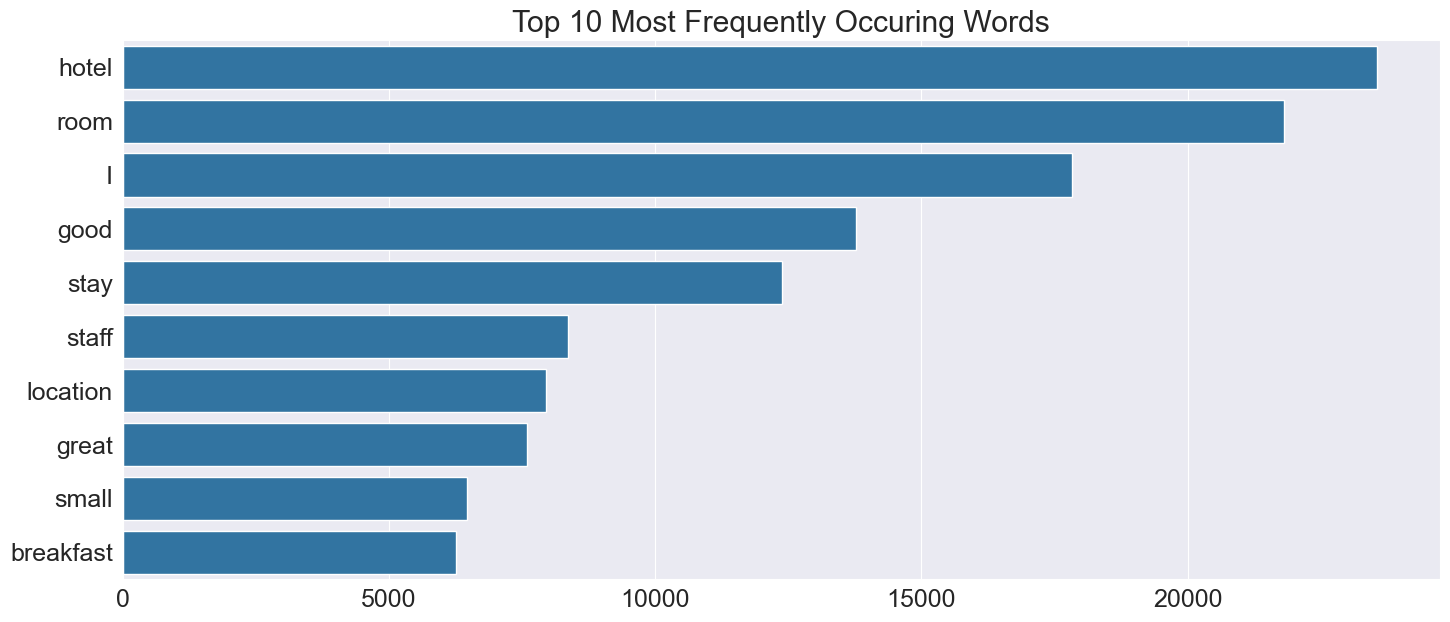

In [40]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

### Most Frequently occuring N_grams

**What is an N-gram?** <br>
An n-gram is sequence of n words in a text. Most words by themselves may not present the entire context. Typically adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyse phrases and not just words which can lead to better insights.
<br>
> A **Bi-gram** means two words in a sequence. 'Very good' or 'Too great'<br>
> A **Tri-gram** means three words in a sequence. 'How was your day' would be broken down to 'How was your' and 'was your day'.<br>

For separating text into n-grams, we will use `CountVectorizer` from Sklearn

#### Bi-Gram

In [41]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['cleaned_review'])

In [42]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

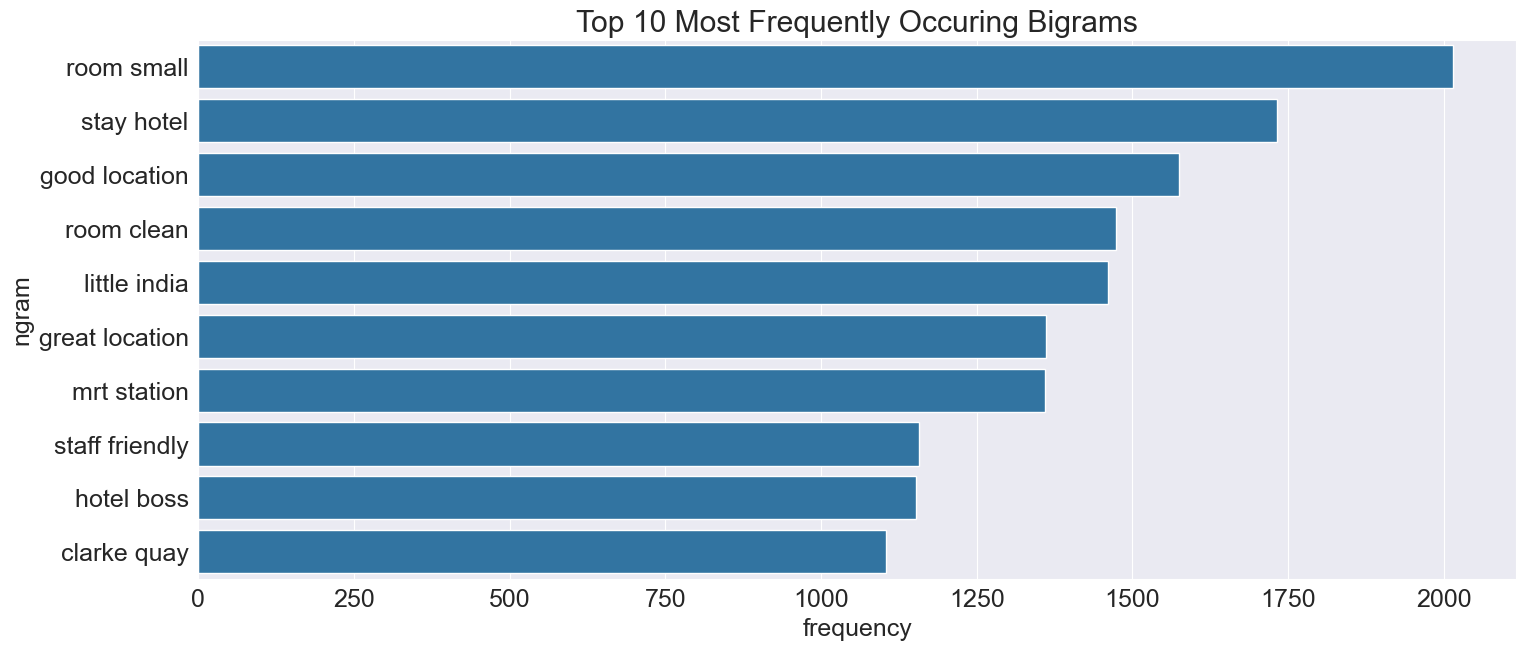

In [43]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

#### Tri-Gram

In [ ]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['cleaned_review'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

In [ ]:
good_reviews = df[df.label == "Positive"]
bad_reviews = df[df.label == "Negative"]

In [ ]:
good_reviews_text = " ".join(good_reviews.combined_review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.combined_review.to_numpy().tolist())

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
stopwords = set(STOPWORDS)

# generate Word Cloud
def gen_wc(txt, cmap):
    w = ['hotel', 'room', 'rooms', 'location', 'staff', 'breakfast', 'bed', 'bathroom'] # selected words to be removed from wordcloud
    stopwords = set(STOPWORDS).union(w)

    # crisp wordcloud : https://stackoverflow.com/a/28795577/11105356
    wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords, colormap = cmap).generate(txt)
    plt.figure(figsize=(14,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [ ]:
gen_wc(good_reviews_text, "summer")

In [ ]:
gen_wc(bad_reviews_text, "YlOrRd")

#### Most frequent N-Gram for positive/negative

#### Bi-Gram

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(good_reviews['cleaned_review'])

In [ ]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams for positive reviews')
plt.show()

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(bad_reviews['cleaned_review'])

In [ ]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams for negative reviews')
plt.show()

#### Tri-Gram

In [ ]:
cv = CountVectorizer(ngram_range=(3,3))
bigrams = cv.fit_transform(good_reviews['cleaned_review'])

In [ ]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams for positive reviews')
plt.show()

In [ ]:
cv = CountVectorizer(ngram_range=(3,3))
bigrams = cv.fit_transform(bad_reviews['cleaned_review'])

In [ ]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams for negative reviews')
plt.show()

## Travel type

### All data

In [27]:
  all_data = combine_csv_to_dataframe(star3+star4+star5, all_star = True)

Length of cleaned_ibis-sg-bencoolen.csv is 5933
Length of cleaned_hotel-boss.csv is 3568
Length of cleaned_hotel-G.csv is 3829
Length of cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 3285
Length of cleaned_holiday-inn-express-clarke-quay.csv is 2551
Length of cleaned_village-hotel-changi-by-far-east-hospitality.csv is 5621
Length of cleaned_park-regis.csv is 5298
Length of cleaned_grand-mercure-sg-roxy.csv is 5015
Length of cleaned_paradox-sg-merchant-court.csv is 5813
Length of cleaned_crowne-plaza.csv is 5743
Length of cleaned_fullerton.csv is 7975
Length of cleaned_parkroyal-collection-marina-bay.csv is 8129
Length of cleaned_pan-pacific.csv is 10797
Length of cleaned_mbs_total.csv is 19371
Length of cleaned_swissotel-the-stamford.csv is 8833


In [28]:
all_data.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     11813
Trip type: Travelled with family      8166
Trip type: Travelled on business      6153
Trip type: Travelled with friends     3044
Trip type: Travelled solo             2178
Name: count, dtype: int64

In [29]:
def short_type(t):
  try:
    return t.split(" ")[-1]
  except:
    return


In [30]:
all_data["travel_type"] = all_data.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x29c1249a0>,
 [Text(0.4153194302011346, 1.0185822357067715, 'couple'),
  Text(-1.0989408602418234, -0.048259565797482, 'family'),
  Text(-0.10125645033994744, -1.0953296906706007, 'business'),
  Text(0.8112303965183192, -0.7429032533006777, 'friends'),
  Text(1.0739103338155485, -0.23815246151190148, 'solo')],
 [Text(0.22653787101880066, 0.5555903103855117, '37.7%\n11813'),
  Text(-0.5994222874046308, -0.02632339952589927, '26.0%\n8166'),
  Text(-0.05523079109451678, -0.5974525585476004, '19.6%\n6153'),
  Text(0.4424893071918104, -0.4052199563458242, '9.7%\n3044'),
  Text(0.585769272990299, -0.12990134264285533, '6.9%\n2178')])

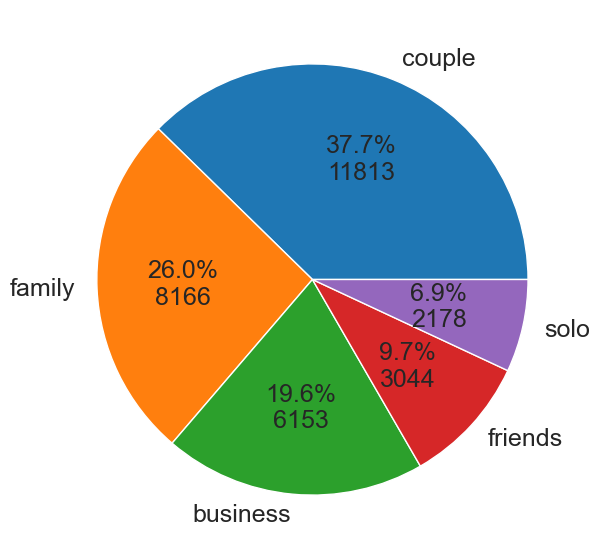

In [31]:
total = all_data['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(all_data['travel_type'].value_counts().values, labels=all_data['travel_type'].value_counts().index, autopct=fmt)


In [32]:
df_plot = all_data.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)

<Figure size 1000x1000 with 0 Axes>

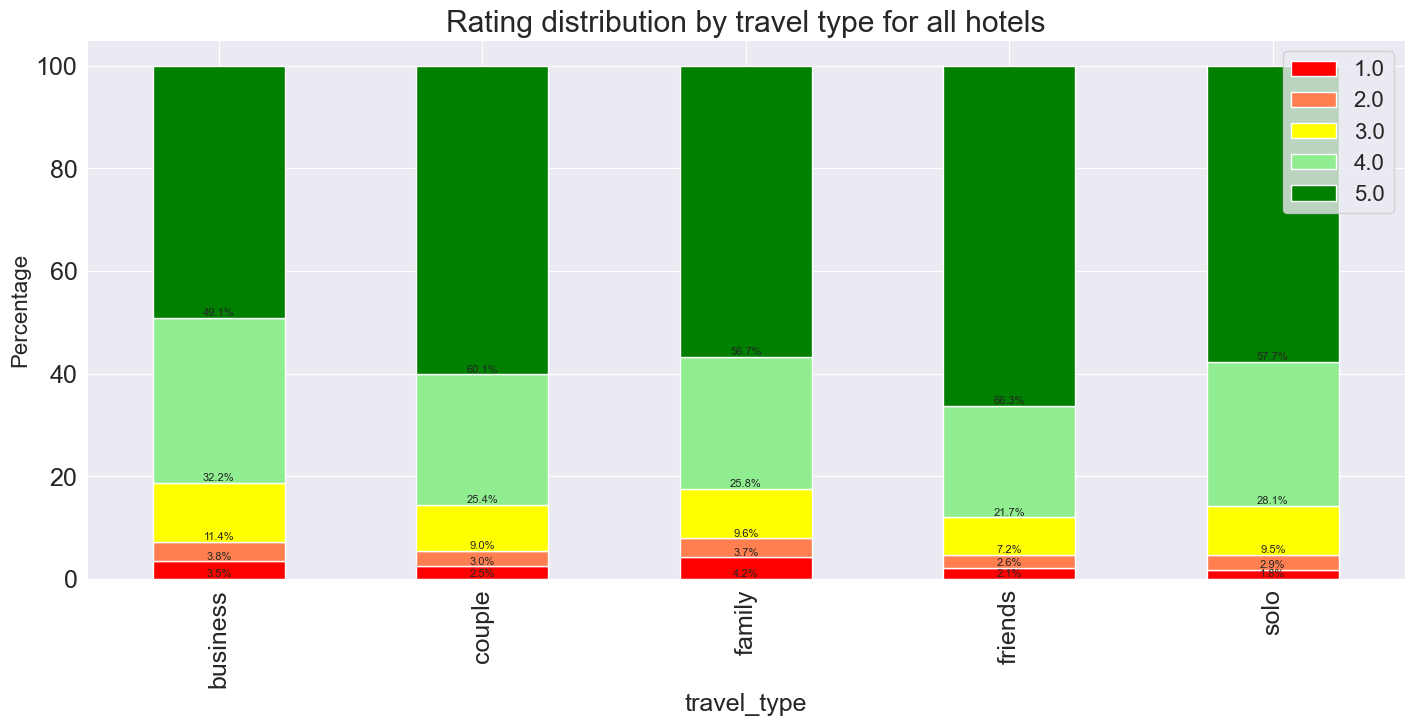

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for all hotels")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


### 3 star

In [34]:
data3 = combine_csv_to_dataframe(star3)

Length of cleaned_ibis-sg-bencoolen.csv is 5933
Length of cleaned_hotel-boss.csv is 3568
Length of cleaned_hotel-G.csv is 3829
Length of cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 3285
Length of cleaned_holiday-inn-express-clarke-quay.csv is 2551


In [35]:
data3.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,year
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,4.0,4.0,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,2023
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,NaN,5.0,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,2023
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,NaN,5.0,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,2022
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,NaN,5.0,True,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,2023
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,4.0,4.0,True,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,2022
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,NaN,5.0,True,Positive,excellent service taste team another excellent...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,ibis-sg-bencoolen,2023
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,NaN,5.0,True,Positive,great care provide hotel engineering team clea...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,ibis-sg-bencoolen,2023
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,NaN,4.0,True,Positive,good hotel stay hotel numerous time remain pre...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,ibis-sg-bencoolen,2023
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,NaN,5.0,True,Positive,special third stay amazing always ibis bencool...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,ibis-sg-bencoolen,2022
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great location,Clean hotel in a convenient location. They hav...,Trip type: Travelled with family,"Bengaluru, India",159.0,145.0,4.0,NaN,4.0,True,Positive,clean hotel great location clean hotel conveni...,Clean hotel at a great location Clean hotel in...,2023-06-01,PostCovid,ibis-sg-bencoolen,2023


In [36]:
data3.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     1547
Trip type: Travelled with family     1312
Trip type: Travelled on business      875
Trip type: Travelled with friends     474
Trip type: Travelled solo             427
Name: count, dtype: int64

In [37]:
data3["travel_type"] = data3.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x29cd04cd0>,
 [Text(0.548708151309369, 0.9533726263569009, 'couple'),
  Text(-1.0867760205298778, 0.17005258363589468, 'family'),
  Text(-0.2653906637548989, -1.0675054077576067, 'business'),
  Text(0.6836714234835137, -0.8617385825829235, 'friends'),
  Text(1.0542506068911823, -0.31393575436635734, 'solo')],
 [Text(0.2992953552596558, 0.5200214325583095, '33.4%\n1547'),
  Text(-0.5927869202890241, 0.09275595471048799, '28.3%\n1312'),
  Text(-0.14475854386630846, -0.5822756769586945, '18.9%\n875'),
  Text(0.37291168553646203, -0.47003922686341276, '10.2%\n474'),
  Text(0.5750457855770085, -0.17123768419983126, '9.2%\n427')])

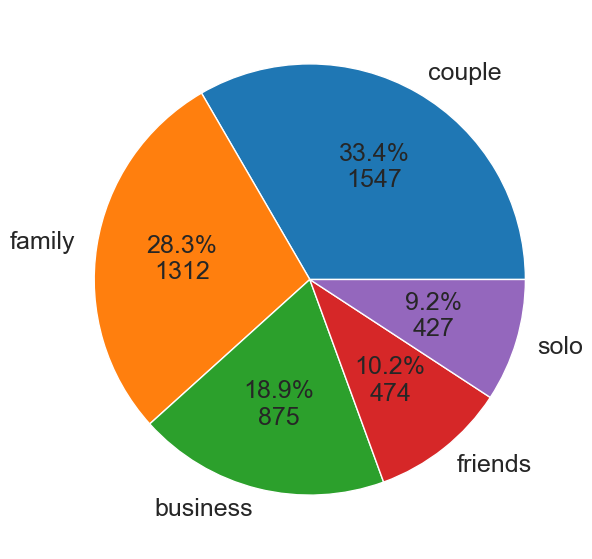

In [38]:
total = data3['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data3['travel_type'].value_counts().values, labels=data3['travel_type'].value_counts().index, autopct=fmt)


In [39]:
df_plot = data3.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)

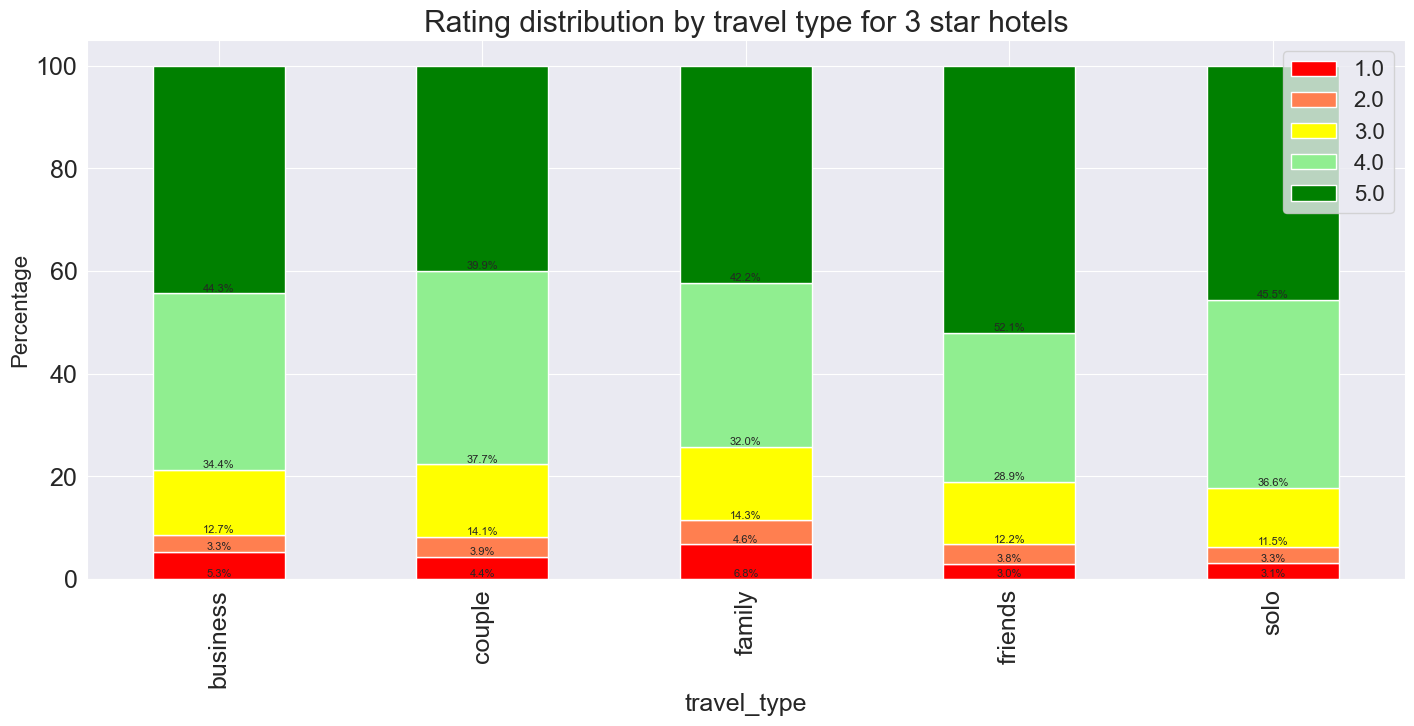

In [40]:
import matplotlib.pyplot as plt

# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for 3 star hotels")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


#### Bencoolen

In [43]:
data3 = pd.read_csv(here('data/cleaned/cleaned_ibis-sg-bencoolen.csv'))
data3["year"] = data3.apply(lambda row: filter_date(row), axis = 1)
data3 = data3[data3["year"]>=2015]

In [44]:
data3.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,year
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,4.0,4.0,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,2023
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,NaN,5.0,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,2023
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,NaN,5.0,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,2022
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,NaN,5.0,True,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,2023
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,4.0,4.0,True,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,2022
5,5,Date of stay: June 2023,David G,Excellent service from the Taste team,Another excellent stay at the IBIS Bencoolen. ...,Trip type: Travelled on business,"Canterbury, United Kingdom",20.0,3.0,5.0,NaN,5.0,True,Positive,excellent service taste team another excellent...,Excellent service from the Taste team Another ...,2023-06-01,PostCovid,2023
6,6,Date of stay: June 2023,Cruiser27845973656,Great care provided by the Hotel Engineering T...,We had a wonderful stay here recently and were...,Trip type: Travelled with family,NaN,1.0,1.0,5.0,NaN,5.0,True,Positive,great care provide hotel engineering team clea...,Great care provided by the Hotel Engineering T...,2023-06-01,PostCovid,2023
7,7,Date of stay: March 2023,roaming_kiwi58,Very good hotel,We have stayed at this hotel numerous times an...,Trip type: Travelled as a couple,"Christchurch, New Zealand",2747.0,642.0,4.0,NaN,4.0,True,Positive,good hotel stay hotel numerous time remain pre...,Very good hotel We have stayed at this hotel n...,2023-03-01,PostCovid,2023
8,8,Date of stay: November 2022,DP_,Special,My third stay here was amazing as always. Ibis...,Trip type: Travelled as a couple,"Kuala Lumpur, Malaysia",5.0,NaN,5.0,NaN,5.0,True,Positive,special third stay amazing always ibis bencool...,Special My third stay here was amazing as alw...,2022-11-01,PostCovid,2022
9,9,Date of stay: June 2023,Radhika A,Clean hotel at a great location,Clean hotel in a convenient location. They hav...,Trip type: Travelled with family,"Bengaluru, India",159.0,145.0,4.0,NaN,4.0,True,Positive,clean hotel great location clean hotel conveni...,Clean hotel at a great location Clean hotel in...,2023-06-01,PostCovid,2023


In [45]:
data3.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     274
Trip type: Travelled on business     187
Trip type: Travelled with family     178
Trip type: Travelled solo             98
Trip type: Travelled with friends     82
Name: count, dtype: int64

In [46]:
data3["travel_type"] = data3.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x103ad11b0>,
 [Text(0.54634175848399, 0.954730686076771, 'couple'),
  Text(-1.0433901091385263, 0.3483347242981874, 'business'),
  Text(-0.5205121709886877, -0.9690547352201749, 'family'),
  Text(0.5896945338817363, -0.9285797524768682, 'solo'),
  Text(1.0460317322194899, -0.340319871870412, 'friends')],
 [Text(0.29800459553672176, 0.5207621924055114, '33.5%\n274'),
  Text(-0.5691218777119234, 0.1900007587081022, '22.8%\n187'),
  Text(-0.2839157296301933, -0.5285753101200954, '21.7%\n178'),
  Text(0.3216515639354925, -0.5064980468055644, '12.0%\n98'),
  Text(0.5705627630288126, -0.18562902102022472, '10.0%\n82')])

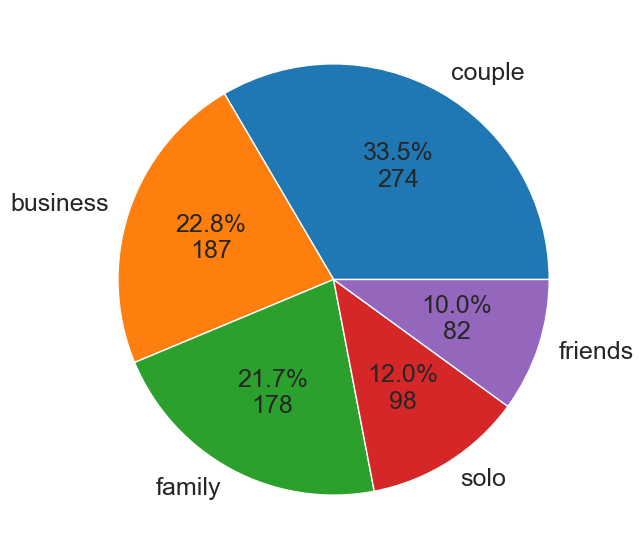

In [47]:
total = data3['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data3['travel_type'].value_counts().values, labels=data3['travel_type'].value_counts().index, autopct=fmt)


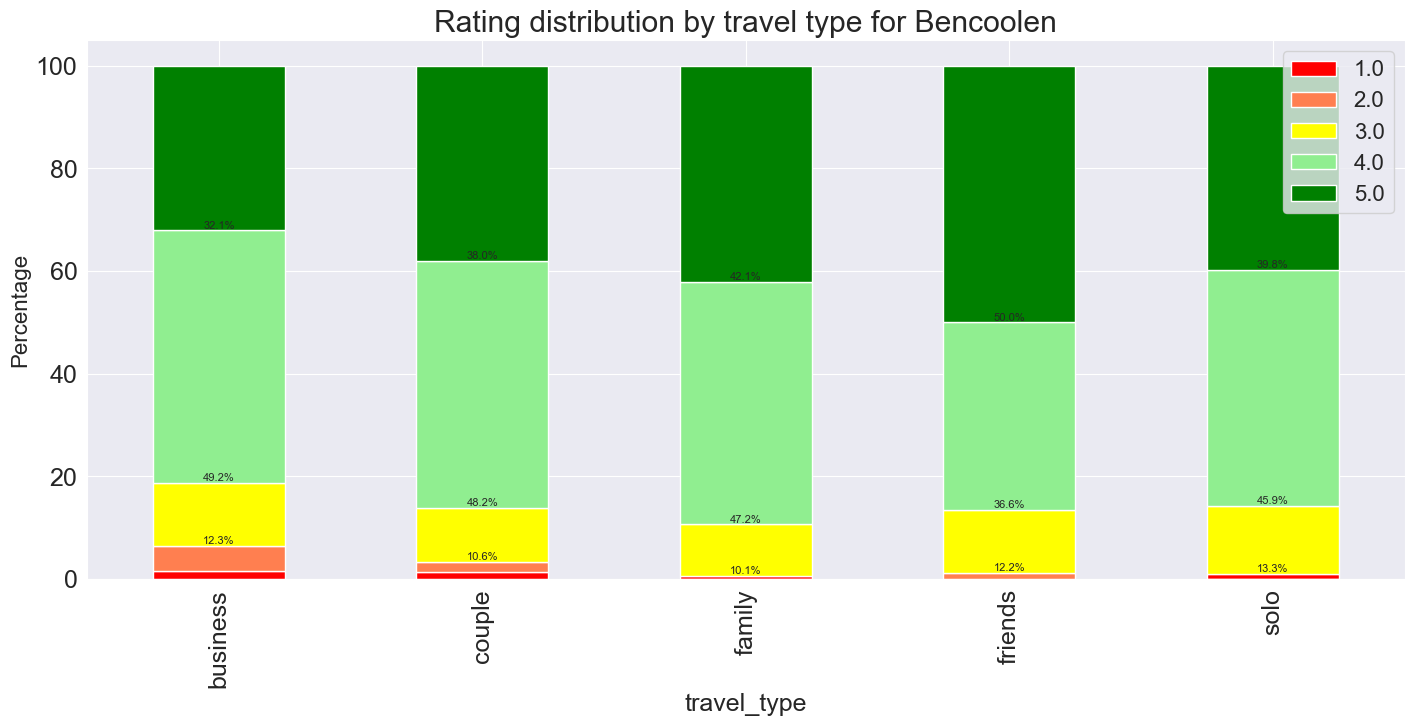

In [48]:
df_plot = data3.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)
# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            if val<5:
              continue
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for Bencoolen")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


### 4 star

In [49]:
data4 = combine_csv_to_dataframe(star4)

Length of cleaned_village-hotel-changi-by-far-east-hospitality.csv is 5621
Length of cleaned_park-regis.csv is 5298
Length of cleaned_grand-mercure-sg-roxy.csv is 5015
Length of cleaned_paradox-sg-merchant-court.csv is 5813
Length of cleaned_crowne-plaza.csv is 5743


In [50]:
data4.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,year
0,0,Date of stay: September 2023,r_salleh12,So affordable,The hotel is so affordable with pool and batht...,NaN,"Singapore, Singapore",1.0,NaN,5.0,NaN,NaN,False,NaN,affordable hotel affordable pool bathtub many ...,So affordable The hotel is so affordable with ...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
1,1,Date of stay: April 2023,Sim N,Good service,"Location is near to airport, quiet surrounding...",Trip type: Travelled solo,"Melbourne, Australia",80.0,33.0,NaN,NaN,NaN,False,NaN,good service location near airport quiet surro...,"Good service Location is near to airport, qui...",2023-04-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
2,2,Date of stay: September 2023,MrsP,Privacy issues a concern,Our stay at the Village Hotel in Changi was OK...,Trip type: Travelled as a couple,"Bordon, United Kingdom",243.0,149.0,NaN,3.0,3.0,True,Neutral,privacy issue concern stay village hotel chang...,Privacy issues a concern Our stay at the Villa...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
3,3,Date of stay: September 2023,suzanahakim606,Love ♥️♥️,Deluxe room at level 7 with balcony. Staff wer...,NaN,"Singapore, Singapore",1.0,NaN,5.0,NaN,NaN,False,NaN,love deluxe room level balcony staff excellent...,Love ♥️♥️ Deluxe room at level 7 with balcony....,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
4,4,Date of stay: September 2023,whughe638814,Village hotel changi,Was told we couldn’t have a double room despit...,NaN,"Edinburgh, United Kingdom",1.0,NaN,1.0,NaN,NaN,False,NaN,village hotel changi tell double room despite ...,Village hotel changi Was told we couldn’t have...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
5,5,Date of stay: September 2023,mtazumi,Nice hotel close to Singapore Changi airport,Stayed at the Village Hotel Changi for a quick...,NaN,"Campbell River, Canada",2.0,1.0,5.0,NaN,NaN,False,NaN,nice hotel close singapore changi airport stay...,Nice hotel close to Singapore Changi airport S...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
6,6,Date of stay: September 2023,rs6ph99144huq18060,late minute cancellation from property and tri...,i have bad experiences your albert court branc...,NaN,"Singapore, Singapore",1.0,NaN,2.0,NaN,NaN,False,NaN,late minute cancellation property trip com hon...,late minute cancellation from property and tri...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
7,7,Date of stay: September 2023,Manfred-Klein-2023,First stay after Corona,Before corona there was a lounge and also a sh...,Trip type: Travelled on business,"Ingelheim, Germany",1.0,NaN,3.0,NaN,NaN,False,NaN,first stay corona corona lounge also shuttle b...,First stay after Corona Before corona there wa...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
8,8,Date of stay: September 2023,DSpalton,Great location and great hotel,"Awesome hotel with fantastic facilities, quiet...",Trip type: Travelled with family,"Fleet, United Kingdom",39.0,33.0,5.0,NaN,NaN,False,NaN,great location great hotel awesome hotel fanta...,Great location and great hotel Awesome hotel w...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023
9,9,Date of stay: September 2023,KarenSapioSexual2576,Not a bad experience,I highly recommend this hotel despite the nois...,NaN,"Singapore, Singapore",1.0,NaN,5.0,NaN,NaN,False,NaN,bad experience I highly recommend hotel despit...,Not a bad experience I highly recommend this h...,2023-09-01,PostCovid,village-hotel-changi-by-far-east-hospitality,2023


In [51]:
data4.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     3217
Trip type: Travelled on business     2114
Trip type: Travelled with family     1825
Trip type: Travelled solo             978
Trip type: Travelled with friends     619
Name: count, dtype: int64

In [52]:
data4["travel_type"] = data4.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x28d1d5930>,
 [Text(0.4446795909022495, 1.0061113563791078, 'couple'),
  Text(-1.0970238079604453, 0.08086262899488435, 'business'),
  Text(-0.25142174740486956, -1.0708814616622524, 'family'),
  Text(0.7700319708952578, -0.7855257881184837, 'solo'),
  Text(1.0729639691300932, -0.24238052922748674, 'friends')],
 [Text(0.2425525041284997, 0.5487880125704224, '36.8%\n3217'),
  Text(-0.5983766225238791, 0.04410688854266418, '24.2%\n2114'),
  Text(-0.13713913494811064, -0.5841171609066831, '20.8%\n1825'),
  Text(0.4200174386701406, -0.4284686117009911, '11.2%\n978'),
  Text(0.5852530740709598, -0.13220756139681092, '7.1%\n619')])

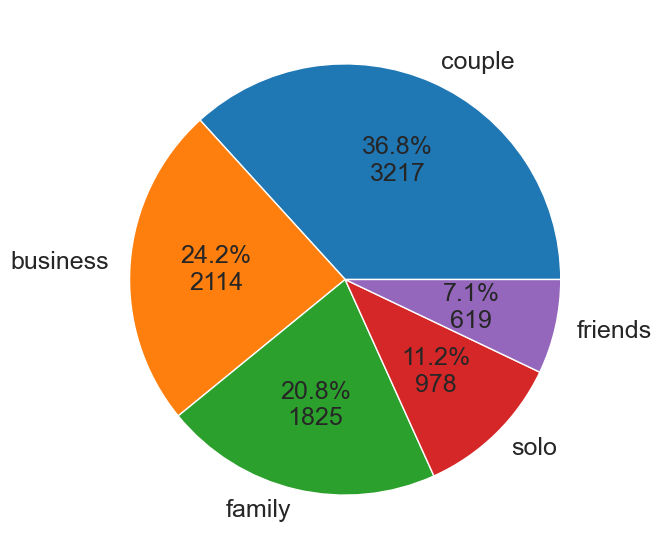

In [53]:
total = data4['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data4['travel_type'].value_counts().values, labels=data4['travel_type'].value_counts().index, autopct=fmt)


In [54]:
df_plot = data4.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)

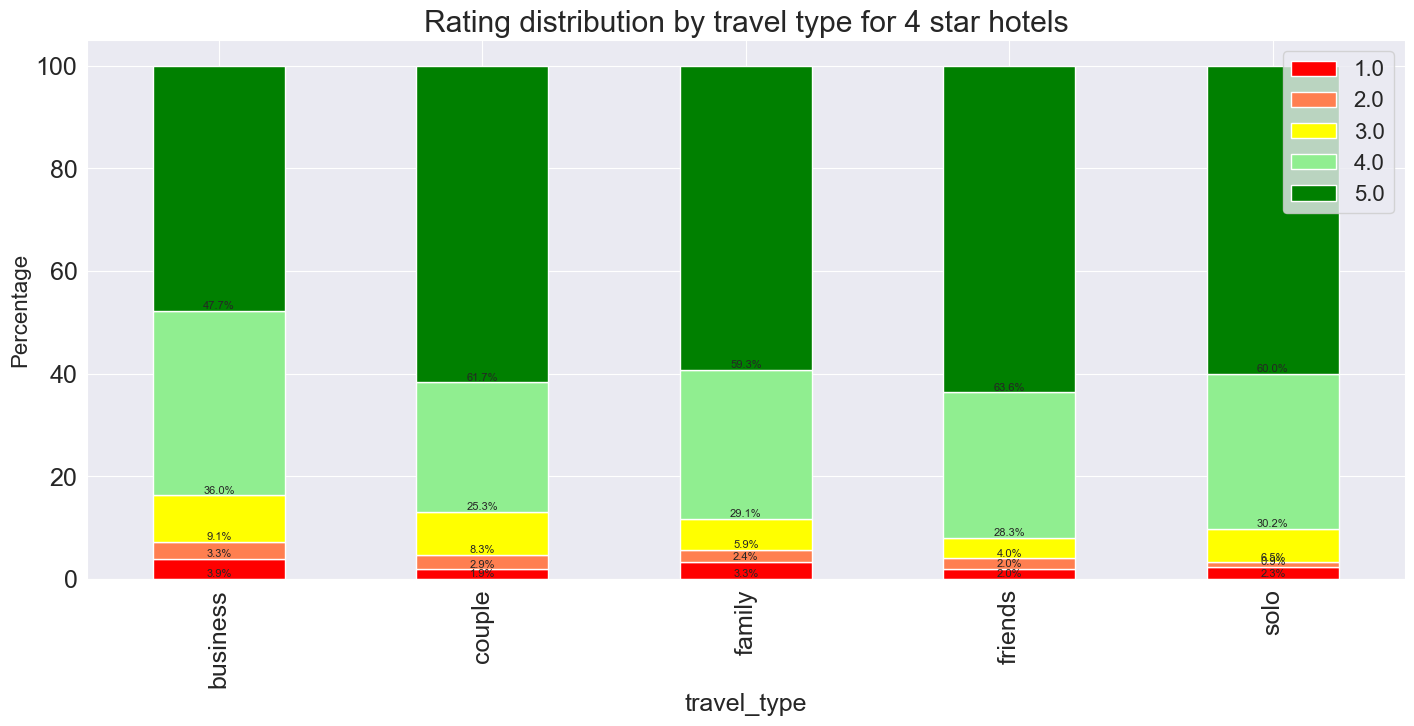

In [55]:
import matplotlib.pyplot as plt

# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for 4 star hotels")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


#### Paradox

In [58]:
data4 = pd.read_csv(here('data/cleaned/cleaned_paradox-sg-merchant-court.csv'))
data4["year"] = data4.apply(lambda row: filter_date(row), axis = 1)
data4 = data4[data4["year"]>=2015]

In [59]:
data4.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,year
0,0,Date of stay: September 2023,Scenic27042346319,My F1 Trip staying place September 2023,The Hotel front-desk was very nice and welcomi...,Trip type: Travelled with friends,NaN,4,NaN,NaN,5.0,5.0,True,Positive,f trip stay place september hotel front desk n...,My F1 Trip staying place September 2023 The Ho...,2023-09-01,PostCovid,2023
1,1,Date of stay: April 2023,gmac73,Great location & excellent staff,Fantastic hotel in a great location! Excellent...,Trip type: Travelled with family,"Melbourne, Australia",61,43.0,NaN,NaN,NaN,False,NaN,great location excellent staff fantastic hotel...,Great location & excellent staff Fantastic hot...,2023-04-01,PostCovid,2023
2,2,Date of stay: September 2023,williefil13,Comfy hotel,"The hotel is well located downtown , close to...",Trip type: Travelled on business,"Singapore, Singapore",1037,187.0,NaN,4.0,4.0,True,Positive,comfy hotel hotel well locate downtown close c...,Comfy hotel The hotel is well located downtow...,2023-09-01,PostCovid,2023
3,3,Date of stay: September 2023,Poosan,Great Stay During F1 September 2023,We stayed here for 5 nights over the F1 Weeken...,Trip type: Travelled as a couple,NaN,750,89.0,5.0,NaN,5.0,True,Positive,great stay f september stay night f weekend ho...,Great Stay During F1 September 2023 We stayed ...,2023-09-01,PostCovid,2023
4,4,Date of stay: March 2023,AJS2015,An excellent hotel!,We stopped over at the Paradox on both legs of...,Trip type: Travelled as a couple,"Calne, United Kingdom",147,84.0,5.0,NaN,5.0,True,Positive,excellent hotel stop paradox leg holiday austr...,An excellent hotel! We stopped over at the Par...,2023-03-01,PostCovid,2023
5,5,Date of stay: September 2023,Angela C,To dine at Ellenborough to celebrate our weddi...,We are not happy with the restriction of area ...,Trip type: Travelled as a couple,NaN,4,3.0,3.0,NaN,3.0,True,Neutral,dine ellenborough celebrate wedding anniversar...,To dine at Ellenborough to celebrate our weddi...,2023-09-01,PostCovid,2023
6,6,Date of stay: September 2023,Maristela Oliveira,"Very nice hotel, friendly team, very good brea...",All the team are very friendly specially Suba ...,Trip type: Travelled as a couple,NaN,5,2.0,5.0,NaN,5.0,True,Positive,nice hotel friendly team good breakfast excele...,"Very nice hotel, friendly team, very good brea...",2023-09-01,PostCovid,2023
7,7,Date of stay: August 2023,Tour46879408504,Very Good Experience,"I had a very good time during my stay, I enjoy...",Trip type: Travelled solo,NaN,1,NaN,NaN,5.0,5.0,True,Positive,good experience I good time stay I enjoy resta...,Very Good Experience I had a very good time du...,2023-08-01,PostCovid,2023
8,8,Date of stay: June 2023,KARDJK,Will stay here every time we visit Singapore,"This hotel is just great - great location, gre...",Trip type: Travelled as a couple,"Leeds, United Kingdom",88,91.0,5.0,NaN,5.0,True,Positive,stay every time visit singapore hotel great gr...,Will stay here every time we visit Singapore T...,2023-06-01,PostCovid,2023
9,9,Date of stay: September 2023,laboot,Wonderful Staycay,Wonderfully located near Clarke Quay including...,Trip type: Travelled with family,"Singapore, Singapore",21,20.0,5.0,NaN,5.0,True,Positive,wonderful staycay wonderfully locate near clar...,Wonderful Staycay Wonderfully located near Cla...,2023-09-01,PostCovid,2023


In [60]:
data4.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     207
Trip type: Travelled with family     140
Trip type: Travelled on business     101
Trip type: Travelled with friends     43
Trip type: Travelled solo             31
Name: count, dtype: int64

In [61]:
data4["travel_type"] = data4.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x28cdbfa00>,
 [Text(0.35123166968774866, 1.0424184928369011, 'couple'),
  Text(-1.0796633801798468, -0.2105397480254685, 'family'),
  Text(0.07937355676574333, -1.0971325528332279, 'business'),
  Text(0.8875781511414993, -0.6497730570100904, 'friends'),
  Text(1.080910938479895, -0.20403809221445168, 'solo')],
 [Text(0.19158091073877198, 0.5685919051837642, '39.7%\n207'),
  Text(-0.5889072982799164, -0.11483986255934643, '26.8%\n140'),
  Text(0.04329466732676908, -0.5984359379090333, '19.3%\n101'),
  Text(0.48413353698627226, -0.3544216674600492, '8.2%\n43'),
  Text(0.5895877846253972, -0.11129350484424635, '5.9%\n31')])

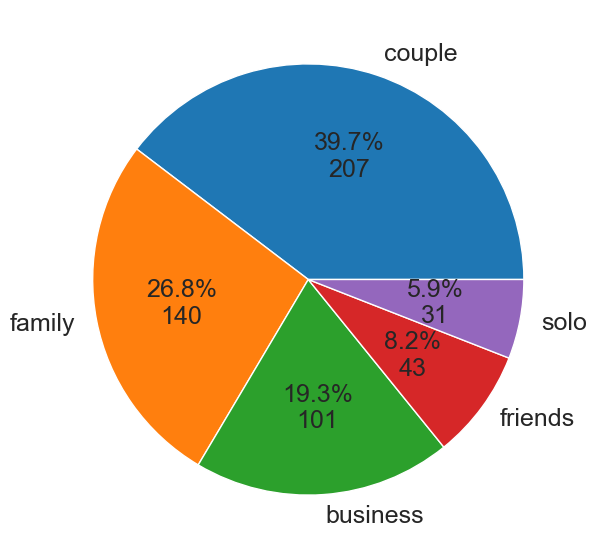

In [62]:
total = data4['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data4['travel_type'].value_counts().values, labels=data4['travel_type'].value_counts().index, autopct=fmt)


In [63]:
df_plot = data4.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)

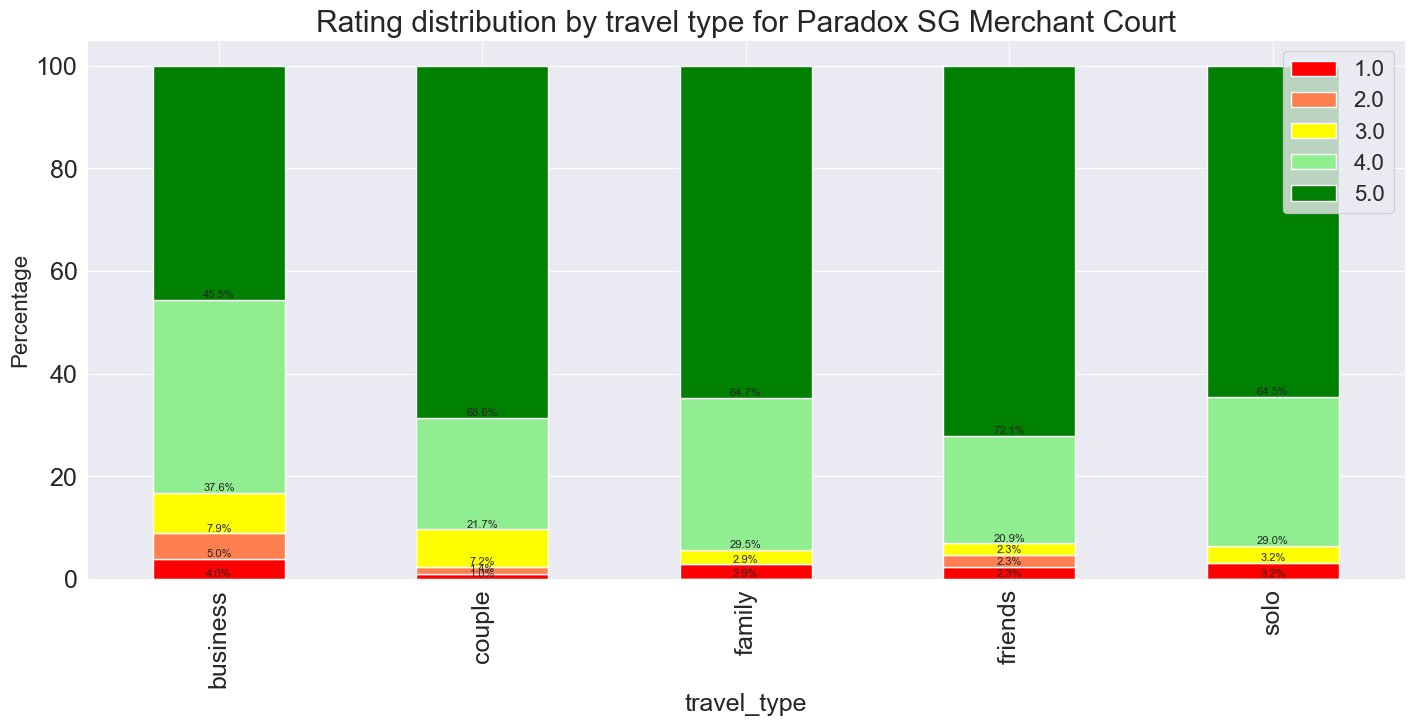

In [64]:
import matplotlib.pyplot as plt

# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for Paradox SG Merchant Court")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


### 5 star

In [65]:
data5 = combine_csv_to_dataframe(star5)

Length of cleaned_fullerton.csv is 7975
Length of cleaned_parkroyal-collection-marina-bay.csv is 8129
Length of cleaned_pan-pacific.csv is 10797
Length of cleaned_mbs_total.csv is 19371
Length of cleaned_swissotel-the-stamford.csv is 8833


In [66]:
data5.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,year
0,0,Date of stay: September 2023,Carolyn H,Sall...the man at the pool!,Sall was so kind and thoughtful every time I w...,Trip type: Travelled as a couple,NaN,1,1.0,5.0,NaN,5.0,True,Positive,sall man pool sall kind thoughtful every time ...,Sall...the man at the pool! Sall was so kind a...,2023-09-01,PostCovid,fullerton,2023
1,1,Date of stay: March 2023,srquarry,Best luxury hotel in Singapore,This has to rate as one of the best hotels we ...,Trip type: Travelled as a couple,"Bath, United Kingdom",17,16.0,NaN,NaN,NaN,False,NaN,good luxury hotel singapore rate one good hote...,Best luxury hotel in Singapore This has to rat...,2023-03-01,PostCovid,fullerton,2023
2,2,Date of stay: August 2023,Maria del Mar M,Concierge team at Fullerton,"This hotel is absolutely perfect for a nice, c...",Trip type: Travelled on business,NaN,1,1.0,5.0,NaN,5.0,True,Positive,concierge team fullerton hotel absolutely perf...,Concierge team at Fullerton This hotel is abso...,2023-08-01,PostCovid,fullerton,2023
3,3,Date of stay: August 2023,MARIA DEL MAR M,PERFECTION,My husband and I are frequent travelers to Sin...,Trip type: Travelled on business,NaN,1,NaN,NaN,5.0,5.0,True,Positive,perfection husband I frequent traveler singapo...,PERFECTION My husband and I are frequent trave...,2023-08-01,PostCovid,fullerton,2023
4,4,Date of stay: September 2023,Alanis K,A warm welcome from the hotel,I had a business trip and got a flu when I arr...,Trip type: Travelled on business,"Hong Kong, China",4,1.0,5.0,NaN,5.0,True,Positive,warm welcome hotel I business trip get flu I a...,A warm welcome from the hotel I had a business...,2023-09-01,PostCovid,fullerton,2023
5,5,Date of stay: August 2023,Jolene B,"Beautiful hotel, great location","Great location and a beautiful hotel, nice com...",Trip type: Travelled with family,NaN,1,NaN,NaN,4.0,4.0,True,Positive,beautiful hotel great location great location ...,"Beautiful hotel, great location Great location...",2023-08-01,PostCovid,fullerton,2023
6,6,Date of stay: September 2023,Navigator25269211532,Wonderful Service by Fullerton Hotel,Have a very warm and lovely services provided ...,Trip type: Travelled as a couple,NaN,1,1.0,NaN,5.0,5.0,True,Positive,wonderful service fullerton hotel warm lovely ...,Wonderful Service by Fullerton Hotel Have a ve...,2023-09-01,PostCovid,fullerton,2023
7,7,Date of stay: September 2023,수영 권,Appreciation for consideration,It was first time to visit Singapore. And it w...,Trip type: Travelled as a couple,NaN,1,NaN,NaN,5.0,5.0,True,Positive,appreciation consideration first time visit si...,Appreciation for consideration It was first ti...,2023-09-01,PostCovid,fullerton,2023
8,8,Date of stay: September 2023,nicki209,Beautiful luxury in the historic part of Singa...,Gorgeous room and great staff the club lounge ...,Trip type: Travelled as a couple,"Rome, Italy",1,NaN,5.0,NaN,5.0,True,Positive,beautiful luxury historic part singapore gorge...,Beautiful luxury in the historic part of Singa...,2023-09-01,PostCovid,fullerton,2023
9,9,Date of stay: October 2022,Smelltheflower,Could be so much more,There are a lot going for Fullerton and I real...,Trip type: Travelled with family,Corner of Earth,1436,353.0,NaN,3.0,3.0,True,Neutral,could much lot go fullerton I really like fixa...,Could be so much more There are a lot going fo...,2022-10-01,PostCovid,fullerton,2022


In [67]:
data5.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     7049
Trip type: Travelled with family     5029
Trip type: Travelled on business     3164
Trip type: Travelled with friends    1951
Trip type: Travelled solo             773
Name: count, dtype: int64

In [68]:
data5["travel_type"] = data5.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x2833c21d0>,
 [Text(0.3649534701282273, 1.0376940611959602, 'couple'),
  Text(-1.0774091761240336, -0.22178698610092346, 'family'),
  Text(0.07131169256551424, -1.0976860400421615, 'business'),
  Text(0.9006686936620869, -0.6315028933085184, 'friends'),
  Text(1.0899663925822187, -0.1482338120716901, 'solo')],
 [Text(0.19906552916085127, 0.5660149424705238, '39.2%\n7049'),
  Text(-0.587677732431291, -0.12097471969141278, '28.0%\n5029'),
  Text(0.03889728685391685, -0.5987378400229971, '17.6%\n3164'),
  Text(0.4912738329065928, -0.3444561236228282, '10.9%\n1951'),
  Text(0.5945271232266647, -0.08085480658455822, '4.3%\n773')])

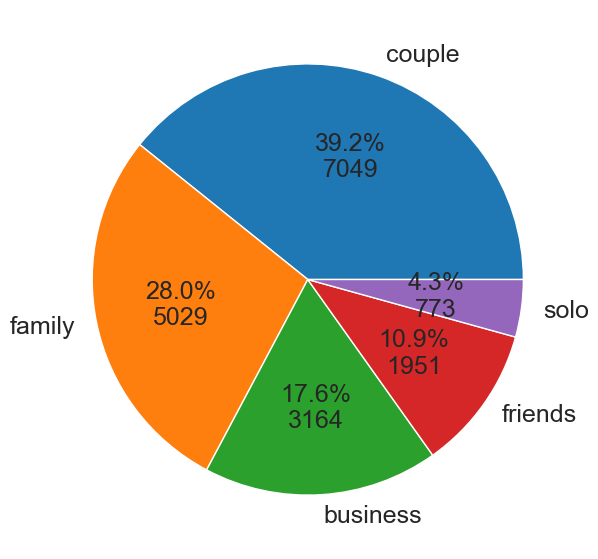

In [69]:
total = data5['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data5['travel_type'].value_counts().values, labels=data5['travel_type'].value_counts().index, autopct=fmt)


In [70]:
df_plot = data5.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)

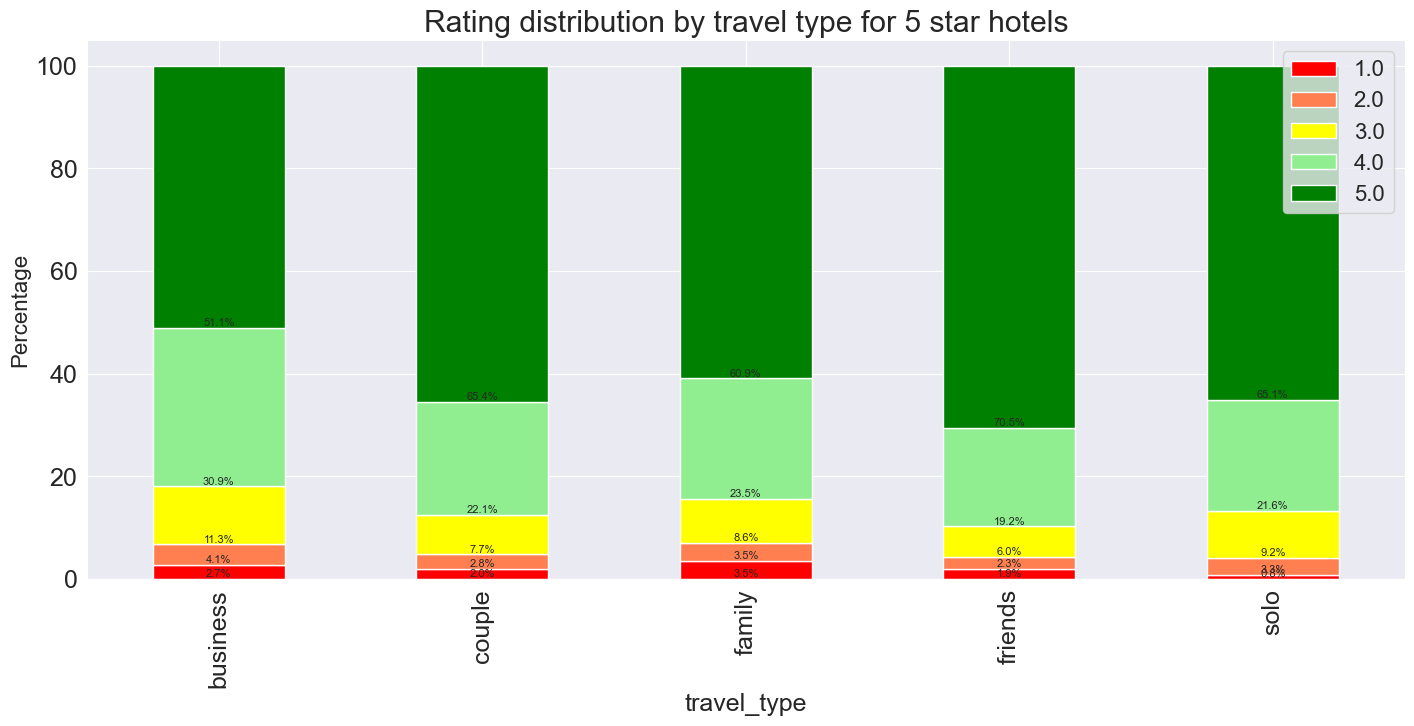

In [71]:
import matplotlib.pyplot as plt

# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for 5 star hotels")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


#### MBS

In [74]:
data5 = pd.read_csv(here('data/cleaned/cleaned_mbs_total.csv'))
data5["year"] = data5.apply(lambda row: filter_date(row), axis = 1)
data5 = data5[data5["year"]>=2015]

In [75]:
data5.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,date,covid,year
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,"Sick in Singapore, and MBS staff were amazing!...",2023-08-01,PostCovid,2023
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,NaN,lovely place go whatever plan whether soak mar...,Lovely place to go whatever you plan to do! Wh...,2023-04-01,PostCovid,2023
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,Thank you for the unforgettable memories I sta...,2023-09-01,PostCovid,2023
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,Amazing hotel but not sure I’d do it again We ...,2023-09-01,PostCovid,2023
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,Stunning hotel and overall an amazing experien...,2023-08-01,PostCovid,2023
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,Perfect stay! One of the best hotels we stayed...,2023-09-01,PostCovid,2023
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,A memorable experience Our experience at Marin...,2023-08-01,PostCovid,2023
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,Beyond infinity Breathtaking garden view plus ...,2023-08-01,PostCovid,2023
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,Disappointing but still worth it for the iconi...,2023-08-01,PostCovid,2023
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,Exceptional The hotel itself is amazing and th...,2023-08-01,PostCovid,2023


In [76]:
data5.travel_type.value_counts()

travel_type
Trip type: Travelled as a couple     2786
Trip type: Travelled with family     1869
Trip type: Travelled with friends     797
Trip type: Travelled on business      686
Trip type: Travelled solo             292
Name: count, dtype: int64

In [77]:
data5["travel_type"] = data5.apply(lambda row: short_type(row["travel_type"]), axis = 1)

([<matplotlib.patches.Wedge at 0x282e2ec20>,
 [Text(0.2288781290603474, 1.075925091276263, 'couple'),
  Text(-0.968509579534097, -0.5215258328699423, 'family'),
  Text(0.24619484050353568, -1.0720951919066883, 'friends'),
  Text(0.894945765427071, -0.6395874271310796, 'business'),
  Text(1.0888244142393069, -0.15640139051949153, 'solo')],
 [Text(0.12484261585109857, 0.5868682316052344, '43.3%\n2786'),
  Text(-0.5282779524731438, -0.2844686361108776, '29.1%\n1869'),
  Text(0.13428809482011037, -0.5847791955854663, '12.4%\n797'),
  Text(0.4881522356874932, -0.34886586934422525, '10.7%\n686'),
  Text(0.5939042259487127, -0.08530984937426811, '4.5%\n292')])

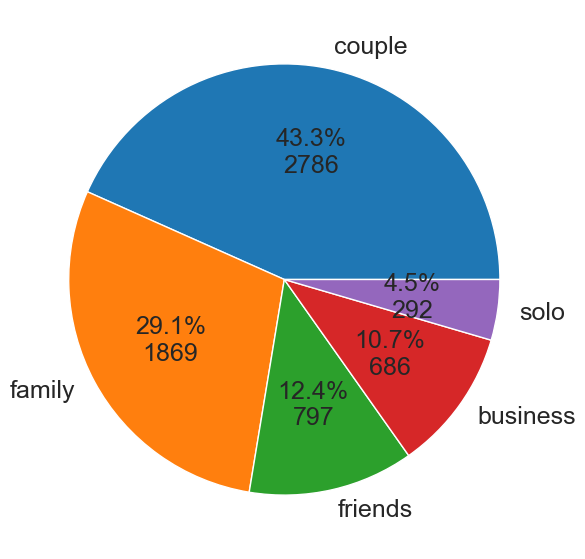

In [78]:
total = data5['travel_type'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data5['travel_type'].value_counts().values, labels=data5['travel_type'].value_counts().index, autopct=fmt)


In [79]:
df_plot = data5.groupby(['travel_type', 'rating']).size().reset_index().pivot(columns='rating', index='travel_type', values=0)

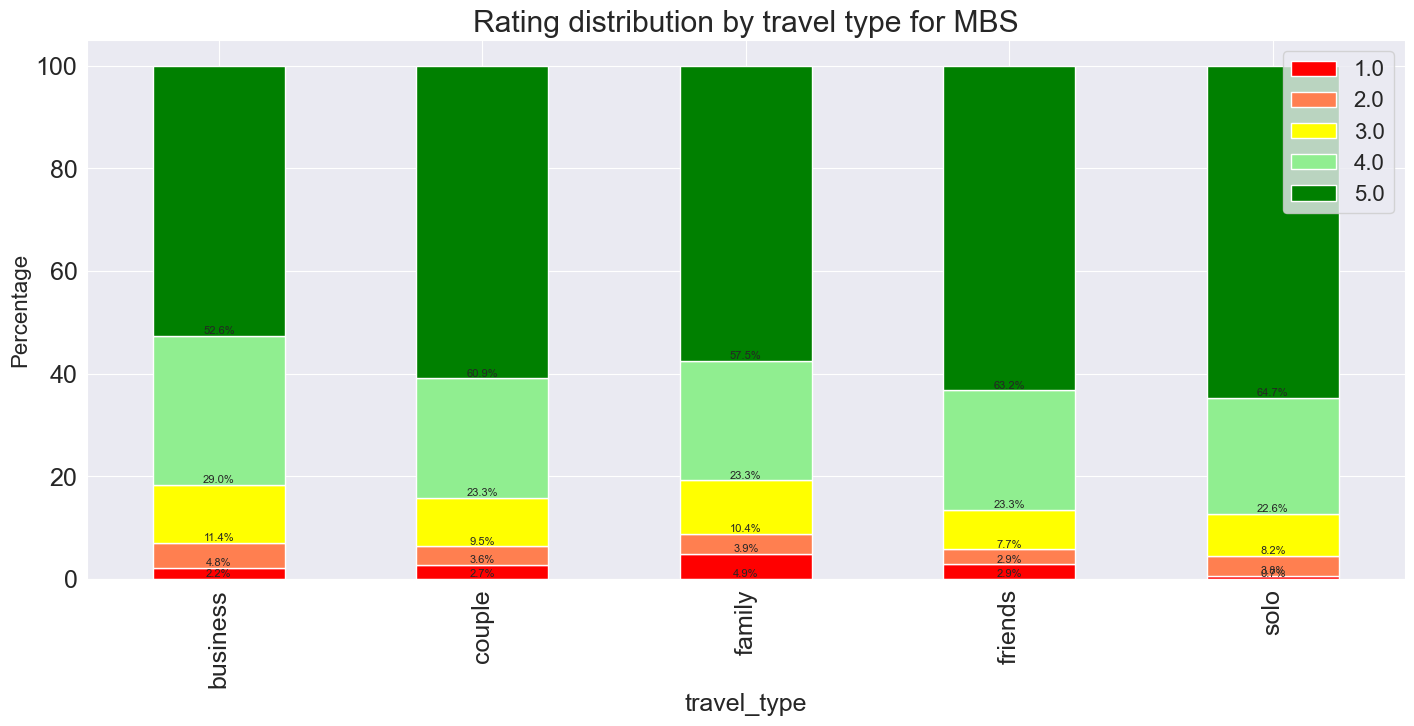

In [80]:
import matplotlib.pyplot as plt

# Calculate the total count for each 'travel_type'
df_plot['total'] = df_plot.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_plot_percentage = df_plot.iloc[:, :-1].div(df_plot['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_plot_percentage.plot(kind='bar', stacked=True, color=['red', 'coral', 'yellow', 'lightgreen', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_plot_percentage.columns):
    for j, val in enumerate(df_plot_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_plot_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Rating distribution by travel type for MBS")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


## Pre and Post Covid comparison

In [91]:
all_data = combine_csv_to_dataframe(star3+star4+star5, all_star = True)

Length of cleaned_ibis-sg-bencoolen.csv is 5933
Length of cleaned_hotel-boss.csv is 3568
Length of cleaned_hotel-G.csv is 3829
Length of cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 3285
Length of cleaned_holiday-inn-express-clarke-quay.csv is 2551
Length of cleaned_village-hotel-changi-by-far-east-hospitality.csv is 5621
Length of cleaned_park-regis.csv is 5298
Length of cleaned_grand-mercure-sg-roxy.csv is 5015
Length of cleaned_paradox-sg-merchant-court.csv is 5813
Length of cleaned_crowne-plaza.csv is 5743
Length of cleaned_fullerton.csv is 7975
Length of cleaned_parkroyal-collection-marina-bay.csv is 8129
Length of cleaned_pan-pacific.csv is 10797
Length of cleaned_mbs_total.csv is 19371
Length of cleaned_swissotel-the-stamford.csv is 8833


In [92]:
# Drop rows without date data
all_data['date'] = pd.to_datetime(all_data.date, format='%Y-%m-%d')
all_data = all_data[~all_data['covid'].isna()]

# Distinguish pre and post covid
pre_covid = all_data[all_data['covid']=='PreCovid']
post_covid = all_data[all_data['covid']=='PostCovid']

### No. of Reviews Each Year

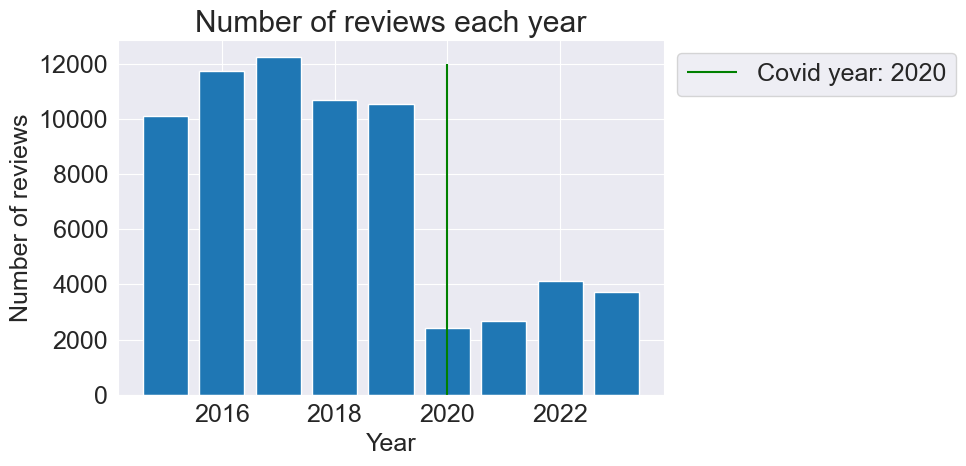

In [93]:
# Create data for bar chart
years = all_data['date'].dt.year.unique().tolist()
years.sort()
bar_data = {}
for year in years:
  bar_data[year] = all_data[all_data['date'].dt.year == year]['date'].count()

# Bar chart
plt.figure(figsize = (10,5))

plt.bar(bar_data.keys(),bar_data.values())

plt.vlines(x = 2020, ymin = 0, ymax = 12000, colors = 'green',
           label = 'Covid year: 2020')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews each year')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.tight_layout()
plt.show()


### No. of Reviews Quarterly

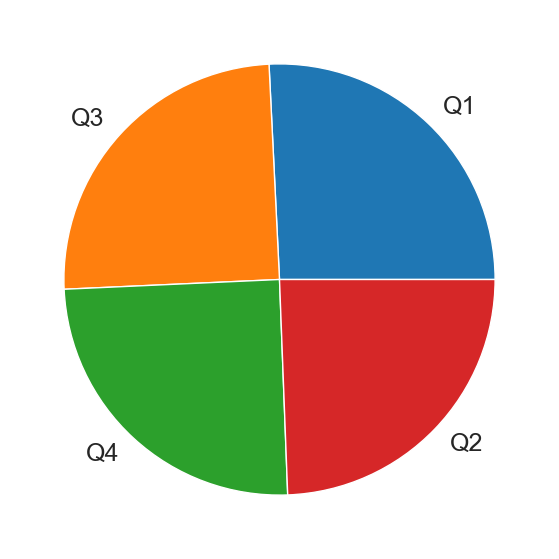

In [94]:
# Create quarter column
all_data['quarter'] = all_data['date'].dt.to_period('Q').astype(str).apply(lambda x: x[4:])

# Create bar chart
plt.figure()
plt.pie(all_data['quarter'].value_counts(), labels = all_data['quarter'].value_counts().index)
plt.show()

### No. of Reviews Monthly

In [95]:
all_data.head()

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,...,valid_rating,label,cleaned_review,combined_review,date,covid,hotel_name,star,year,quarter
0,0,Date of stay: August 2023,Love_Life_Sydney,Clean and comfortable,Hotel rooms in Singapore are so expensive so t...,Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,NaN,...,True,Positive,clean comfortable hotel room singapore expensi...,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,Q3
1,1,Date of stay: August 2023,Bilal S,"Good hotel, great location",This is a great place! Location is great but t...,Trip type: Travelled with family,"Houston, Texas",4.0,NaN,5.0,...,True,Positive,good hotel great location great place location...,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,Q3
2,2,Date of stay: October 2022,Anthony Fernando,Good place for a decent price.,Good place good price Easy access to the city...,Trip type: Travelled with friends,"Dubai, United Arab Emirates",39.0,38.0,5.0,...,True,Positive,good place decent price good place good price ...,Good place for a decent price. Good place good...,2022-10-01,PostCovid,ibis-sg-bencoolen,3,2022,Q4
3,3,Date of stay: August 2023,Mjkc204,Great Location and great staff.,The IBIS was a neat and tidy hotel in line wit...,Trip type: Travelled solo,"Ellenbrook, Australia",37.0,19.0,5.0,...,True,Positive,great location great staff ibis neat tidy hote...,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,ibis-sg-bencoolen,3,2023,Q3
4,4,Date of stay: August 2022,Aung Nanda,Good for budget stay.,I stayed there for 7 days. It was a nice locat...,Trip type: Travelled on business,"Dubai, United Arab Emirates",3.0,4.0,NaN,...,True,Positive,good budget stay I stay day nice location seve...,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,ibis-sg-bencoolen,3,2022,Q3


In [96]:
# Group by month and year
monthly_reviews = all_data.groupby(['year', 'month']).size()

# Create a bar chart
monthly_reviews.plot(kind='line', figsize=(10, 5))

# Customize the chart
plt.title('Count of Reviews by Month for Different Years')
plt.xlabel('Year and Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed

# Display the chart
plt.tight_layout()
plt.show()

KeyError: 'month'

In [ ]:
# Create column for Month
all_data['month'] = all_data['date'].dt.month

# Get params for barchart
years = all_data['year'].unique().tolist()
years.sort()
no_cols = 2
no_rows = len(years) // 2 + 1
custom_xtick_labels = ['Jan', 'Feb', 'Mar', 'Apr',
                       'May', 'Jun', 'Jul', 'Aug',
                       'Sep', 'Oct', 'Nov', 'Dec']

# Initiate barchart
fig, axs = plt.subplots(nrows=no_rows,
                        ncols=no_cols,
                        figsize=(15, 12),
                        sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Number of reviews for each month", fontsize=18, y=0.95)

# Loop through tickers and axes
for year, ax in zip(years, axs.ravel()):

    # filter df for year
    df = all_data[all_data['year'] == year]
    monthly_reviews = df.groupby('month')['month'].count()

    # Get number of reviews for that month
    ax.bar(monthly_reviews.index, monthly_reviews.values)
    ax.set_title(f"Monthly reviews count for {str(year)}")
    ax.set_xlabel('Month')
    ax.set_ylabel('Reviews Count')
    ax.set_xticklabels(custom_xtick_labels)

plt.tight_layout()
plt.show()

In [ ]:
df_breakdown = all_data.copy()
df_breakdown['year'] = df_breakdown['date'].dt.year.astype(int)
df_breakdown = df_breakdown.groupby(['year', 'label']).size().reset_index().pivot(columns='label', index='year', values=0)

# Calculate the total count for each year
df_breakdown['total'] = df_breakdown.sum(axis=1)

# Calculate the percentages for each category within each 'travel_type'
df_breakdown_percentage = df_breakdown.iloc[:, :-1].div(df_breakdown['total'], axis=0) * 100

# Plot the stacked bar chart with percentages and annotations
ax = df_breakdown_percentage.plot(kind='bar', stacked=True, color=['red', 'grey', 'green'])

# Add annotations (percentages) above the bars with smaller font size
for i, col in enumerate(df_breakdown_percentage.columns):
    for j, val in enumerate(df_breakdown_percentage[col]):
        if not pd.isna(val):  # Skip NaN values
            # Calculate the y-position for each annotation (top of the bar)
            y_position = df_breakdown_percentage.iloc[:, :i].sum(axis=1).iloc[j]
            ax.text(j, y_position, f'{val:.1f}%', ha='center', va='bottom', fontsize=8)  # Adjust font size

# Set the y-axis label to 'Percentage' with smaller font size
ax.set_ylabel('Percentage', fontsize=16)  # Adjust font size for the y-axis label

# Display the plot
plt.title("Breakdown of all sentiments for all years")
plt.legend(fontsize=16)  # Adjust legend font size
plt.show()


### Mention of words in each year
We check the occurance of words in reviews. We check the words 'room','location','staff','clean', as these were the top words in reviews

In [ ]:
# Create column for year
all_data['year'] = all_data['date'].dt.year.astype(int)

# Check reviews with words
def check(df, word):
  reviews_with_word = df.copy()
  col_name = 'contains_' + word

  # Get percentage of reviews containing word in df
  reviews_with_word[col_name] = reviews_with_word['cleaned_review'].apply(lambda x: word in x)
  reviews_with_word = reviews_with_word.groupby(['year',col_name]).size().reset_index().pivot(columns=col_name, index='year', values=0)
  reviews_with_word['total'] = reviews_with_word.sum(axis = 1)
  reviews_with_word = reviews_with_word.reset_index()
  reviews_with_word['percentage_of_reviews_with_word'] = reviews_with_word[True] / reviews_with_word['total']
  return reviews_with_word

#### Positive reviews

In [ ]:
positive_reviews = all_data[all_data['label']=='Positive']

# Find percentage of reviews containing word for each word
room_reviews = check(positive_reviews, 'room')
location_reviews = check(positive_reviews, 'location')
staff_reviews = check(positive_reviews, 'staff')
clean_reviews = check(positive_reviews, 'clean')

In [ ]:
# Initialising plot
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1,
                                           figsize = (5,10),
                                           sharex=True, sharey=True)

# plot bar charts
ax1.bar(x = room_reviews['year'], height = room_reviews['percentage_of_reviews_with_word'])
ax2.bar(x = location_reviews['year'], height = location_reviews['percentage_of_reviews_with_word'])
ax3.bar(x = staff_reviews['year'], height = staff_reviews['percentage_of_reviews_with_word'])
ax4.bar(x = clean_reviews['year'], height = clean_reviews['percentage_of_reviews_with_word'])

# Display plot
fig.suptitle('Positive Reviews')
ax1.set_title("Percentage of reviews containing word \'room\' over the years")
ax2.set_title("Percentage of reviews containing word \'location\' over the years")
ax3.set_title("Percentage of reviews containing word \'staff\' over the years")
ax4.set_title("Percentage of reviews containing word \'clean\' over the years")

for ax in fig.get_axes():
    ax.label_outer()
    ax.vlines(x = 2020, ymin = 0, ymax = 1, colors = 'green',
              label = 'Covid year: 2020')

fig.tight_layout()
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

#### Negative Reviews

In [ ]:
negative_reviews = all_data[all_data['label']=='Negative']

# Find percentage of reviews containing word for each word
room_reviews = check(negative_reviews, 'room')
location_reviews = check(negative_reviews, 'location')
staff_reviews = check(negative_reviews, 'staff')
clean_reviews = check(negative_reviews, 'clean')

In [ ]:
# Initialising plot
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1,
                                           figsize = (5,10),
                                           sharex=True, sharey=True)

# plot bar charts
ax1.bar(x = room_reviews['year'], height = room_reviews['percentage_of_reviews_with_word'])
ax2.bar(x = location_reviews['year'], height = location_reviews['percentage_of_reviews_with_word'])
ax3.bar(x = staff_reviews['year'], height = staff_reviews['percentage_of_reviews_with_word'])
ax4.bar(x = clean_reviews['year'], height = clean_reviews['percentage_of_reviews_with_word'])

# Display plot
fig.suptitle('Negative Reviews')
ax1.set_title("Percentage of reviews containing word \'room\' over the years")
ax2.set_title("Percentage of reviews containing word \'location\' over the years")
ax3.set_title("Percentage of reviews containing word \'staff\' over the years")
ax4.set_title("Percentage of reviews containing word \'clean\' over the years")

for ax in fig.get_axes():
    ax.label_outer()
    ax.vlines(x = 2020, ymin = 0, ymax = 1, colors = 'green',
              label = 'Covid year: 2020')

fig.tight_layout()
ax1.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')